In [173]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [174]:
def retrieveCfbData(endpoint, team, year, week):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType=regular&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [175]:
# init data retrieval
teams = pd.read_csv("data/teams/2018.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2016, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys)

/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [176]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 3289
Total Drives: 84218
Total Plays: 595530


In [177]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

Clean Drives: 83699


In [178]:
pbp_data.distance = pbp_data.distance.astype(float)

pbp_data.drop(['offense_conference','defense_conference'], axis = 1, inplace=True) 
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]

bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

In [179]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if (play.play_type in bad_types):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [202]:
def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[pbp.offense == team]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    havoc = calculate_havoc_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'HavocRate': [havoc]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def calculate_five_factors_rating(team_stat_pack):
    return (35 * team_stat_pack.OffSR) + (25 * (team_stat_pack.YPP / 10)) + (15 * (team_stat_pack.FP / 50.0)) + (15 * ((team_stat_pack.OppPPD * team_stat_pack.OppEff) + (team_stat_pack.PPD * team_stat_pack.OppRate))) + (10 * (team_stat_pack.HavocRate * team_stat_pack.ExpTODiff))

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if (year == 2016):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = game_pbp.apply(lambda x: x.yards_gained >= 15, axis=1)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = game_pbp.apply(lambda x: is_successful_vector(x), axis=1)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')
    
    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    home_team_stats['ExpTODiff'] = home_team_stats['ExpTO'] - away_team_stats['ExpTO']
    away_team_stats['ExpTODiff'] = away_team_stats['ExpTO'] - home_team_stats['ExpTO']
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,26.0,2.214286,0.833333,0.428571,0.567568,5.166667,1.15,0.118421,-0.66,115.995178,29.075969
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,31.4,2.266667,0.625000,0.533333,0.448980,3.375000,1.81,0.158730,0.66,86.919209,-29.075969


In [203]:
stored_game_boxes = pd.DataFrame()
game_ids = games.id.unique()
team_list = teams.school.tolist()
for i, row in games.iterrows():
    gameId = row.id
    print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}")
    print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}")
    if ((row.home_team in team_list) & (row.away_team in team_list)):
        box_score = calculate_box_score(gameId, row.season)
        if (box_score is not None):
            game_tms = box_score.Team.tolist()
            print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}")
            stored_game_boxes = stored_game_boxes.append(box_score)
            print(f"[{i+1}/{len(game_ids)}] Aggreggating game_id {gameId} to master data copy")
        else:
            print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing")
    else:
        print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS")

[1/3289] Getting game information for ESPN game_id: 400869090
[1/3289] Started processing game information for ESPN game_id: 400869090
[1/3289] Completed processing game information for ESPN game_id: 400869090
[1/3289] Aggreggating game_id 400869090 to master data copy
[2/3289] Getting game information for ESPN game_id: 400869421
[2/3289] Started processing game information for ESPN game_id: 400869421
[2/3289] Completed processing game information for ESPN game_id: 400869421
[2/3289] Aggreggating game_id 400869421 to master data copy
[3/3289] Getting game information for ESPN game_id: 400869257
[3/3289] Started processing game information for ESPN game_id: 400869257
[3/3289] Skipping checking game_id 400869257 bc one of the teams isn't FBS
[4/3289] Getting game information for ESPN game_id: 400869502
[4/3289] Started processing game information for ESPN game_id: 400869502
[4/3289] Skipping checking game_id 400869502 bc one of the teams isn't FBS
[5/3289] Getting game information for ES

[35/3289] Completed processing game information for ESPN game_id: 400868976
[35/3289] Aggreggating game_id 400868976 to master data copy
[36/3289] Getting game information for ESPN game_id: 400869507
[36/3289] Started processing game information for ESPN game_id: 400869507
[36/3289] Completed processing game information for ESPN game_id: 400869507
[36/3289] Aggreggating game_id 400869507 to master data copy
[37/3289] Getting game information for ESPN game_id: 400869260
[37/3289] Started processing game information for ESPN game_id: 400869260
[37/3289] Completed processing game information for ESPN game_id: 400869260
[37/3289] Aggreggating game_id 400869260 to master data copy
[38/3289] Getting game information for ESPN game_id: 400869509
[38/3289] Started processing game information for ESPN game_id: 400869509
[38/3289] Skipping checking game_id 400869509 bc one of the teams isn't FBS
[39/3289] Getting game information for ESPN game_id: 400869267
[39/3289] Started processing game infor

[74/3289] Completed processing game information for ESPN game_id: 400868969
[74/3289] Aggreggating game_id 400868969 to master data copy
[75/3289] Getting game information for ESPN game_id: 400868887
[75/3289] Started processing game information for ESPN game_id: 400868887
[75/3289] Skipping checking game_id 400868887 bc one of the teams isn't FBS
[76/3289] Getting game information for ESPN game_id: 400869179
[76/3289] Started processing game information for ESPN game_id: 400869179
[76/3289] Completed processing game information for ESPN game_id: 400869179
[76/3289] Aggreggating game_id 400869179 to master data copy
[77/3289] Getting game information for ESPN game_id: 400869098
[77/3289] Started processing game information for ESPN game_id: 400869098
[77/3289] Skipping checking game_id 400869098 bc one of the teams isn't FBS
[78/3289] Getting game information for ESPN game_id: 400869348
[78/3289] Started processing game information for ESPN game_id: 400869348
[78/3289] Completed proces

[109/3289] Completed processing game information for ESPN game_id: 400869277
[109/3289] Aggreggating game_id 400869277 to master data copy
[110/3289] Getting game information for ESPN game_id: 400869433
[110/3289] Started processing game information for ESPN game_id: 400869433
[110/3289] Skipping checking game_id 400869433 bc one of the teams isn't FBS
[111/3289] Getting game information for ESPN game_id: 400868877
[111/3289] Started processing game information for ESPN game_id: 400868877
[111/3289] Completed processing game information for ESPN game_id: 400868877
[111/3289] Aggreggating game_id 400868877 to master data copy
[112/3289] Getting game information for ESPN game_id: 400868980
[112/3289] Started processing game information for ESPN game_id: 400868980
[112/3289] Completed processing game information for ESPN game_id: 400868980
[112/3289] Aggreggating game_id 400868980 to master data copy
[113/3289] Getting game information for ESPN game_id: 400869516
[113/3289] Started proces

[144/3289] Completed processing game information for ESPN game_id: 400868981
[144/3289] Aggreggating game_id 400868981 to master data copy
[145/3289] Getting game information for ESPN game_id: 400869357
[145/3289] Started processing game information for ESPN game_id: 400869357
[145/3289] Completed processing game information for ESPN game_id: 400869357
[145/3289] Aggreggating game_id 400869357 to master data copy
[146/3289] Getting game information for ESPN game_id: 400868888
[146/3289] Started processing game information for ESPN game_id: 400868888
[146/3289] Completed processing game information for ESPN game_id: 400868888
[146/3289] Aggreggating game_id 400868888 to master data copy
[147/3289] Getting game information for ESPN game_id: 400868985
[147/3289] Started processing game information for ESPN game_id: 400868985
[147/3289] Skipping checking game_id 400868985 bc one of the teams isn't FBS
[148/3289] Getting game information for ESPN game_id: 400868982
[148/3289] Started proces

[176/3289] Completed processing game information for ESPN game_id: 400869281
[176/3289] Aggreggating game_id 400869281 to master data copy
[177/3289] Getting game information for ESPN game_id: 400869519
[177/3289] Started processing game information for ESPN game_id: 400869519
[177/3289] Completed processing game information for ESPN game_id: 400869519
[177/3289] Aggreggating game_id 400869519 to master data copy
[178/3289] Getting game information for ESPN game_id: 400869520
[178/3289] Started processing game information for ESPN game_id: 400869520
[178/3289] Completed processing game information for ESPN game_id: 400869520
[178/3289] Aggreggating game_id 400869520 to master data copy
[179/3289] Getting game information for ESPN game_id: 400869001
[179/3289] Started processing game information for ESPN game_id: 400869001
[179/3289] Completed processing game information for ESPN game_id: 400869001
[179/3289] Aggreggating game_id 400869001 to master data copy
[180/3289] Getting game inf

[209/3289] Completed processing game information for ESPN game_id: 400868993
[209/3289] Aggreggating game_id 400868993 to master data copy
[210/3289] Getting game information for ESPN game_id: 400868996
[210/3289] Started processing game information for ESPN game_id: 400868996
[210/3289] Completed processing game information for ESPN game_id: 400868996
[210/3289] Aggreggating game_id 400868996 to master data copy
[211/3289] Getting game information for ESPN game_id: 400869521
[211/3289] Started processing game information for ESPN game_id: 400869521
[211/3289] Completed processing game information for ESPN game_id: 400869521
[211/3289] Aggreggating game_id 400869521 to master data copy
[212/3289] Getting game information for ESPN game_id: 400869522
[212/3289] Started processing game information for ESPN game_id: 400869522
[212/3289] Completed processing game information for ESPN game_id: 400869522
[212/3289] Aggreggating game_id 400869522 to master data copy
[213/3289] Getting game inf

[240/3289] Completed processing game information for ESPN game_id: 400869363
[240/3289] Aggreggating game_id 400869363 to master data copy
[241/3289] Getting game information for ESPN game_id: 400869204
[241/3289] Started processing game information for ESPN game_id: 400869204
[241/3289] Completed processing game information for ESPN game_id: 400869204
[241/3289] Aggreggating game_id 400869204 to master data copy
[242/3289] Getting game information for ESPN game_id: 400869203
[242/3289] Started processing game information for ESPN game_id: 400869203
[242/3289] Completed processing game information for ESPN game_id: 400869203
[242/3289] Aggreggating game_id 400869203 to master data copy
[243/3289] Getting game information for ESPN game_id: 400869288
[243/3289] Started processing game information for ESPN game_id: 400869288
[243/3289] Completed processing game information for ESPN game_id: 400869288
[243/3289] Aggreggating game_id 400869288 to master data copy
[244/3289] Getting game inf

[272/3289] Completed processing game information for ESPN game_id: 400869365
[272/3289] Aggreggating game_id 400869365 to master data copy
[273/3289] Getting game information for ESPN game_id: 400868913
[273/3289] Started processing game information for ESPN game_id: 400868913
[273/3289] Completed processing game information for ESPN game_id: 400868913
[273/3289] Aggreggating game_id 400868913 to master data copy
[274/3289] Getting game information for ESPN game_id: 400869815
[274/3289] Started processing game information for ESPN game_id: 400869815
[274/3289] Skipping checking game_id 400869815 bc one of the teams isn't FBS
[275/3289] Getting game information for ESPN game_id: 400869605
[275/3289] Started processing game information for ESPN game_id: 400869605
[275/3289] Skipping checking game_id 400869605 bc one of the teams isn't FBS
[276/3289] Getting game information for ESPN game_id: 400869004
[276/3289] Started processing game information for ESPN game_id: 400869004
[276/3289] C

[305/3289] Completed processing game information for ESPN game_id: 400869294
[305/3289] Aggreggating game_id 400869294 to master data copy
[306/3289] Getting game information for ESPN game_id: 400869296
[306/3289] Started processing game information for ESPN game_id: 400869296
[306/3289] Completed processing game information for ESPN game_id: 400869296
[306/3289] Aggreggating game_id 400869296 to master data copy
[307/3289] Getting game information for ESPN game_id: 400869127
[307/3289] Started processing game information for ESPN game_id: 400869127
[307/3289] Completed processing game information for ESPN game_id: 400869127
[307/3289] Aggreggating game_id 400869127 to master data copy
[308/3289] Getting game information for ESPN game_id: 400869295
[308/3289] Started processing game information for ESPN game_id: 400869295
[308/3289] Completed processing game information for ESPN game_id: 400869295
[308/3289] Aggreggating game_id 400869295 to master data copy
[309/3289] Getting game inf

[336/3289] Completed processing game information for ESPN game_id: 400869374
[336/3289] Aggreggating game_id 400869374 to master data copy
[337/3289] Getting game information for ESPN game_id: 400869014
[337/3289] Started processing game information for ESPN game_id: 400869014
[337/3289] Completed processing game information for ESPN game_id: 400869014
[337/3289] Aggreggating game_id 400869014 to master data copy
[338/3289] Getting game information for ESPN game_id: 400869373
[338/3289] Started processing game information for ESPN game_id: 400869373
[338/3289] Completed processing game information for ESPN game_id: 400869373
[338/3289] Aggreggating game_id 400869373 to master data copy
[339/3289] Getting game information for ESPN game_id: 400869821
[339/3289] Started processing game information for ESPN game_id: 400869821
[339/3289] Skipping checking game_id 400869821 bc one of the teams isn't FBS
[340/3289] Getting game information for ESPN game_id: 400869453
[340/3289] Started proces

[367/3289] Completed processing game information for ESPN game_id: 400869458
[367/3289] Aggreggating game_id 400869458 to master data copy
[368/3289] Getting game information for ESPN game_id: 400869300
[368/3289] Started processing game information for ESPN game_id: 400869300
[368/3289] Completed processing game information for ESPN game_id: 400869300
[368/3289] Aggreggating game_id 400869300 to master data copy
[369/3289] Getting game information for ESPN game_id: 400869302
[369/3289] Started processing game information for ESPN game_id: 400869302
[369/3289] Completed processing game information for ESPN game_id: 400869302
[369/3289] Aggreggating game_id 400869302 to master data copy
[370/3289] Getting game information for ESPN game_id: 400869304
[370/3289] Started processing game information for ESPN game_id: 400869304
[370/3289] Completed processing game information for ESPN game_id: 400869304
[370/3289] Aggreggating game_id 400869304 to master data copy
[371/3289] Getting game inf

[398/3289] Completed processing game information for ESPN game_id: 400869130
[398/3289] Aggreggating game_id 400869130 to master data copy
[399/3289] Getting game information for ESPN game_id: 400869215
[399/3289] Started processing game information for ESPN game_id: 400869215
[399/3289] Completed processing game information for ESPN game_id: 400869215
[399/3289] Aggreggating game_id 400869215 to master data copy
[400/3289] Getting game information for ESPN game_id: 400869218
[400/3289] Started processing game information for ESPN game_id: 400869218
[400/3289] Completed processing game information for ESPN game_id: 400869218
[400/3289] Aggreggating game_id 400869218 to master data copy
[401/3289] Getting game information for ESPN game_id: 400869135
[401/3289] Started processing game information for ESPN game_id: 400869135
[401/3289] Completed processing game information for ESPN game_id: 400869135
[401/3289] Aggreggating game_id 400869135 to master data copy
[402/3289] Getting game inf

[429/3289] Completed processing game information for ESPN game_id: 400869827
[429/3289] Aggreggating game_id 400869827 to master data copy
[430/3289] Getting game information for ESPN game_id: 400869028
[430/3289] Started processing game information for ESPN game_id: 400869028
[430/3289] Completed processing game information for ESPN game_id: 400869028
[430/3289] Aggreggating game_id 400869028 to master data copy
[431/3289] Getting game information for ESPN game_id: 400869463
[431/3289] Started processing game information for ESPN game_id: 400869463
[431/3289] Completed processing game information for ESPN game_id: 400869463
[431/3289] Aggreggating game_id 400869463 to master data copy
[432/3289] Getting game information for ESPN game_id: 400869306
[432/3289] Started processing game information for ESPN game_id: 400869306
Could not find drive data for game_id 400869306 locally, checking CFB Data API
Could not find drive data for game_id 400869306 bc of issues with 2016 data source, bai

[458/3289] Completed processing game information for ESPN game_id: 400869222
[458/3289] Aggreggating game_id 400869222 to master data copy
[459/3289] Getting game information for ESPN game_id: 400869467
[459/3289] Started processing game information for ESPN game_id: 400869467
[459/3289] Completed processing game information for ESPN game_id: 400869467
[459/3289] Aggreggating game_id 400869467 to master data copy
[460/3289] Getting game information for ESPN game_id: 400869830
[460/3289] Started processing game information for ESPN game_id: 400869830
[460/3289] Completed processing game information for ESPN game_id: 400869830
[460/3289] Aggreggating game_id 400869830 to master data copy
[461/3289] Getting game information for ESPN game_id: 400869224
[461/3289] Started processing game information for ESPN game_id: 400869224
[461/3289] Completed processing game information for ESPN game_id: 400869224
[461/3289] Aggreggating game_id 400869224 to master data copy
[462/3289] Getting game inf

[488/3289] Completed processing game information for ESPN game_id: 400869546
[488/3289] Aggreggating game_id 400869546 to master data copy
[489/3289] Getting game information for ESPN game_id: 400869831
[489/3289] Started processing game information for ESPN game_id: 400869831
[489/3289] Skipping checking game_id 400869831 bc one of the teams isn't FBS
[490/3289] Getting game information for ESPN game_id: 400869833
[490/3289] Started processing game information for ESPN game_id: 400869833
[490/3289] Skipping checking game_id 400869833 bc one of the teams isn't FBS
[491/3289] Getting game information for ESPN game_id: 400869312
[491/3289] Started processing game information for ESPN game_id: 400869312
[491/3289] Completed processing game information for ESPN game_id: 400869312
[491/3289] Aggreggating game_id 400869312 to master data copy
[492/3289] Getting game information for ESPN game_id: 400869547
[492/3289] Started processing game information for ESPN game_id: 400869547
[492/3289] C

[518/3289] Completed processing game information for ESPN game_id: 400869317
[518/3289] Aggreggating game_id 400869317 to master data copy
[519/3289] Getting game information for ESPN game_id: 400869835
[519/3289] Started processing game information for ESPN game_id: 400869835
[519/3289] Completed processing game information for ESPN game_id: 400869835
[519/3289] Aggreggating game_id 400869835 to master data copy
[520/3289] Getting game information for ESPN game_id: 400869145
[520/3289] Started processing game information for ESPN game_id: 400869145
[520/3289] Completed processing game information for ESPN game_id: 400869145
[520/3289] Aggreggating game_id 400869145 to master data copy
[521/3289] Getting game information for ESPN game_id: 400869548
[521/3289] Started processing game information for ESPN game_id: 400869548
[521/3289] Completed processing game information for ESPN game_id: 400869548
[521/3289] Aggreggating game_id 400869548 to master data copy
[522/3289] Getting game inf

[549/3289] Completed processing game information for ESPN game_id: 400869553
[549/3289] Aggreggating game_id 400869553 to master data copy
[550/3289] Getting game information for ESPN game_id: 400869147
[550/3289] Started processing game information for ESPN game_id: 400869147
[550/3289] Completed processing game information for ESPN game_id: 400869147
[550/3289] Aggreggating game_id 400869147 to master data copy
[551/3289] Getting game information for ESPN game_id: 400869837
[551/3289] Started processing game information for ESPN game_id: 400869837
[551/3289] Completed processing game information for ESPN game_id: 400869837
[551/3289] Aggreggating game_id 400869837 to master data copy
[552/3289] Getting game information for ESPN game_id: 400869836
[552/3289] Started processing game information for ESPN game_id: 400869836
[552/3289] Completed processing game information for ESPN game_id: 400869836
[552/3289] Aggreggating game_id 400869836 to master data copy
[553/3289] Getting game inf

[579/3289] Completed processing game information for ESPN game_id: 400869236
[579/3289] Aggreggating game_id 400869236 to master data copy
[580/3289] Getting game information for ESPN game_id: 400868954
[580/3289] Started processing game information for ESPN game_id: 400868954
[580/3289] Completed processing game information for ESPN game_id: 400868954
[580/3289] Aggreggating game_id 400868954 to master data copy
[581/3289] Getting game information for ESPN game_id: 400869045
[581/3289] Started processing game information for ESPN game_id: 400869045
[581/3289] Completed processing game information for ESPN game_id: 400869045
[581/3289] Aggreggating game_id 400869045 to master data copy
[582/3289] Getting game information for ESPN game_id: 400869630
[582/3289] Started processing game information for ESPN game_id: 400869630
[582/3289] Completed processing game information for ESPN game_id: 400869630
[582/3289] Aggreggating game_id 400869630 to master data copy
[583/3289] Getting game inf

[611/3289] Completed processing game information for ESPN game_id: 400869047
[611/3289] Aggreggating game_id 400869047 to master data copy
[612/3289] Getting game information for ESPN game_id: 400921256
[612/3289] Started processing game information for ESPN game_id: 400921256
[612/3289] Completed processing game information for ESPN game_id: 400921256
[612/3289] Aggreggating game_id 400921256 to master data copy
[613/3289] Getting game information for ESPN game_id: 400869841
[613/3289] Started processing game information for ESPN game_id: 400869841
[613/3289] Completed processing game information for ESPN game_id: 400869841
[613/3289] Aggreggating game_id 400869841 to master data copy
[614/3289] Getting game information for ESPN game_id: 400869840
[614/3289] Started processing game information for ESPN game_id: 400869840
[614/3289] Skipping checking game_id 400869840 bc one of the teams isn't FBS
[615/3289] Getting game information for ESPN game_id: 400869398
[615/3289] Started proces

[643/3289] Completed processing game information for ESPN game_id: 400869631
[643/3289] Aggreggating game_id 400869631 to master data copy
[644/3289] Getting game information for ESPN game_id: 400869054
[644/3289] Started processing game information for ESPN game_id: 400869054
[644/3289] Completed processing game information for ESPN game_id: 400869054
[644/3289] Aggreggating game_id 400869054 to master data copy
[645/3289] Getting game information for ESPN game_id: 400869557
[645/3289] Started processing game information for ESPN game_id: 400869557
[645/3289] Completed processing game information for ESPN game_id: 400869557
[645/3289] Aggreggating game_id 400869557 to master data copy
[646/3289] Getting game information for ESPN game_id: 400869558
[646/3289] Started processing game information for ESPN game_id: 400869558
[646/3289] Completed processing game information for ESPN game_id: 400869558
[646/3289] Aggreggating game_id 400869558 to master data copy
[647/3289] Getting game inf

[675/3289] Completed processing game information for ESPN game_id: 400869559
[675/3289] Aggreggating game_id 400869559 to master data copy
[676/3289] Getting game information for ESPN game_id: 400869407
[676/3289] Started processing game information for ESPN game_id: 400869407
[676/3289] Completed processing game information for ESPN game_id: 400869407
[676/3289] Aggreggating game_id 400869407 to master data copy
[677/3289] Getting game information for ESPN game_id: 400869242
[677/3289] Started processing game information for ESPN game_id: 400869242
[677/3289] Completed processing game information for ESPN game_id: 400869242
[677/3289] Aggreggating game_id 400869242 to master data copy
[678/3289] Getting game information for ESPN game_id: 400869050
[678/3289] Started processing game information for ESPN game_id: 400869050
[678/3289] Completed processing game information for ESPN game_id: 400869050
[678/3289] Aggreggating game_id 400869050 to master data copy
[679/3289] Getting game inf

[705/3289] Completed processing game information for ESPN game_id: 400869059
[705/3289] Aggreggating game_id 400869059 to master data copy
[706/3289] Getting game information for ESPN game_id: 400869414
[706/3289] Started processing game information for ESPN game_id: 400869414
[706/3289] Completed processing game information for ESPN game_id: 400869414
[706/3289] Aggreggating game_id 400869414 to master data copy
[707/3289] Getting game information for ESPN game_id: 400869694
[707/3289] Started processing game information for ESPN game_id: 400869694
[707/3289] Completed processing game information for ESPN game_id: 400869694
[707/3289] Aggreggating game_id 400869694 to master data copy
[708/3289] Getting game information for ESPN game_id: 400869494
[708/3289] Started processing game information for ESPN game_id: 400869494
[708/3289] Completed processing game information for ESPN game_id: 400869494
[708/3289] Aggreggating game_id 400869494 to master data copy
[709/3289] Getting game inf

[737/3289] Completed processing game information for ESPN game_id: 400869412
[737/3289] Aggreggating game_id 400869412 to master data copy
[738/3289] Getting game information for ESPN game_id: 400869251
[738/3289] Started processing game information for ESPN game_id: 400869251
[738/3289] Completed processing game information for ESPN game_id: 400869251
[738/3289] Aggreggating game_id 400869251 to master data copy
[739/3289] Getting game information for ESPN game_id: 400869062
[739/3289] Started processing game information for ESPN game_id: 400869062
[739/3289] Completed processing game information for ESPN game_id: 400869062
[739/3289] Aggreggating game_id 400869062 to master data copy
[740/3289] Getting game information for ESPN game_id: 400869565
[740/3289] Started processing game information for ESPN game_id: 400869565
[740/3289] Completed processing game information for ESPN game_id: 400869565
[740/3289] Aggreggating game_id 400869565 to master data copy
[741/3289] Getting game inf

[770/3289] Completed processing game information for ESPN game_id: 400868885
[770/3289] Aggreggating game_id 400868885 to master data copy
[771/3289] Getting game information for ESPN game_id: 400869567
[771/3289] Started processing game information for ESPN game_id: 400869567
[771/3289] Completed processing game information for ESPN game_id: 400869567
[771/3289] Aggreggating game_id 400869567 to master data copy
[772/3289] Getting game information for ESPN game_id: 400869167
[772/3289] Started processing game information for ESPN game_id: 400869167
[772/3289] Completed processing game information for ESPN game_id: 400869167
[772/3289] Aggreggating game_id 400869167 to master data copy
[773/3289] Getting game information for ESPN game_id: 400869701
[773/3289] Started processing game information for ESPN game_id: 400869701
[773/3289] Completed processing game information for ESPN game_id: 400869701
[773/3289] Aggreggating game_id 400869701 to master data copy
[774/3289] Getting game inf

[800/3289] Completed processing game information for ESPN game_id: 400869171
[800/3289] Aggreggating game_id 400869171 to master data copy
[801/3289] Getting game information for ESPN game_id: 400869570
[801/3289] Started processing game information for ESPN game_id: 400869570
[801/3289] Completed processing game information for ESPN game_id: 400869570
[801/3289] Aggreggating game_id 400869570 to master data copy
[802/3289] Getting game information for ESPN game_id: 400869417
[802/3289] Started processing game information for ESPN game_id: 400869417
[802/3289] Completed processing game information for ESPN game_id: 400869417
[802/3289] Aggreggating game_id 400869417 to master data copy
[803/3289] Getting game information for ESPN game_id: 400869415
[803/3289] Started processing game information for ESPN game_id: 400869415
[803/3289] Completed processing game information for ESPN game_id: 400869415
[803/3289] Aggreggating game_id 400869415 to master data copy
[804/3289] Getting game inf

[832/3289] Completed processing game information for ESPN game_id: 400868921
[832/3289] Aggreggating game_id 400868921 to master data copy
[833/3289] Getting game information for ESPN game_id: 400935282
[833/3289] Started processing game information for ESPN game_id: 400935282
[833/3289] Completed processing game information for ESPN game_id: 400935282
[833/3289] Aggreggating game_id 400935282 to master data copy
[834/3289] Getting game information for ESPN game_id: 400945031
[834/3289] Started processing game information for ESPN game_id: 400945031
[834/3289] Skipping checking game_id 400945031 bc one of the teams isn't FBS
[835/3289] Getting game information for ESPN game_id: 400938887
[835/3289] Started processing game information for ESPN game_id: 400938887
[835/3289] Completed processing game information for ESPN game_id: 400938887
[835/3289] Aggreggating game_id 400938887 to master data copy
[836/3289] Getting game information for ESPN game_id: 400941786
[836/3289] Started proces

[868/3289] Completed processing game information for ESPN game_id: 400935256
[868/3289] Aggreggating game_id 400935256 to master data copy
[869/3289] Getting game information for ESPN game_id: 400937449
[869/3289] Started processing game information for ESPN game_id: 400937449
[869/3289] Skipping checking game_id 400937449 bc one of the teams isn't FBS
[870/3289] Getting game information for ESPN game_id: 400937450
[870/3289] Started processing game information for ESPN game_id: 400937450
[870/3289] Skipping checking game_id 400937450 bc one of the teams isn't FBS
[871/3289] Getting game information for ESPN game_id: 400935254
[871/3289] Started processing game information for ESPN game_id: 400935254
[871/3289] Skipping checking game_id 400935254 bc one of the teams isn't FBS
[872/3289] Getting game information for ESPN game_id: 400945246
[872/3289] Started processing game information for ESPN game_id: 400945246
[872/3289] Skipping checking game_id 400945246 bc one of the teams isn't F

[904/3289] Completed processing game information for ESPN game_id: 400935238
[904/3289] Aggreggating game_id 400935238 to master data copy
[905/3289] Getting game information for ESPN game_id: 400945251
[905/3289] Started processing game information for ESPN game_id: 400945251
[905/3289] Skipping checking game_id 400945251 bc one of the teams isn't FBS
[906/3289] Getting game information for ESPN game_id: 400934488
[906/3289] Started processing game information for ESPN game_id: 400934488
[906/3289] Skipping checking game_id 400934488 bc one of the teams isn't FBS
[907/3289] Getting game information for ESPN game_id: 400933827
[907/3289] Started processing game information for ESPN game_id: 400933827
[907/3289] Completed processing game information for ESPN game_id: 400933827
[907/3289] Aggreggating game_id 400933827 to master data copy
[908/3289] Getting game information for ESPN game_id: 400945247
[908/3289] Started processing game information for ESPN game_id: 400945247
[908/3289] S

[938/3289] Completed processing game information for ESPN game_id: 400934499
[938/3289] Aggreggating game_id 400934499 to master data copy
[939/3289] Getting game information for ESPN game_id: 400937455
[939/3289] Started processing game information for ESPN game_id: 400937455
[939/3289] Skipping checking game_id 400937455 bc one of the teams isn't FBS
[940/3289] Getting game information for ESPN game_id: 400937453
[940/3289] Started processing game information for ESPN game_id: 400937453
[940/3289] Completed processing game information for ESPN game_id: 400937453
[940/3289] Aggreggating game_id 400937453 to master data copy
[941/3289] Getting game information for ESPN game_id: 400935262
[941/3289] Started processing game information for ESPN game_id: 400935262
[941/3289] Completed processing game information for ESPN game_id: 400935262
[941/3289] Aggreggating game_id 400935262 to master data copy
[942/3289] Getting game information for ESPN game_id: 400938605
[942/3289] Started proces

[974/3289] Completed processing game information for ESPN game_id: 400938601
[974/3289] Aggreggating game_id 400938601 to master data copy
[975/3289] Getting game information for ESPN game_id: 400944833
[975/3289] Started processing game information for ESPN game_id: 400944833
[975/3289] Skipping checking game_id 400944833 bc one of the teams isn't FBS
[976/3289] Getting game information for ESPN game_id: 400933852
[976/3289] Started processing game information for ESPN game_id: 400933852
[976/3289] Skipping checking game_id 400933852 bc one of the teams isn't FBS
[977/3289] Getting game information for ESPN game_id: 400944898
[977/3289] Started processing game information for ESPN game_id: 400944898
[977/3289] Completed processing game information for ESPN game_id: 400944898
[977/3289] Aggreggating game_id 400944898 to master data copy
[978/3289] Getting game information for ESPN game_id: 400933850
[978/3289] Started processing game information for ESPN game_id: 400933850
[978/3289] C

[1005/3289] Completed processing game information for ESPN game_id: 400935352
[1005/3289] Aggreggating game_id 400935352 to master data copy
[1006/3289] Getting game information for ESPN game_id: 400934513
[1006/3289] Started processing game information for ESPN game_id: 400934513
[1006/3289] Skipping checking game_id 400934513 bc one of the teams isn't FBS
[1007/3289] Getting game information for ESPN game_id: 400934509
[1007/3289] Started processing game information for ESPN game_id: 400934509
[1007/3289] Completed processing game information for ESPN game_id: 400934509
[1007/3289] Aggreggating game_id 400934509 to master data copy
[1008/3289] Getting game information for ESPN game_id: 400937465
[1008/3289] Started processing game information for ESPN game_id: 400937465
[1008/3289] Skipping checking game_id 400937465 bc one of the teams isn't FBS
[1009/3289] Getting game information for ESPN game_id: 400934506
[1009/3289] Started processing game information for ESPN game_id: 40093450

[1039/3289] Completed processing game information for ESPN game_id: 400935273
[1039/3289] Aggreggating game_id 400935273 to master data copy
[1040/3289] Getting game information for ESPN game_id: 400944839
[1040/3289] Started processing game information for ESPN game_id: 400944839
[1040/3289] Skipping checking game_id 400944839 bc one of the teams isn't FBS
[1041/3289] Getting game information for ESPN game_id: 400944840
[1041/3289] Started processing game information for ESPN game_id: 400944840
[1041/3289] Skipping checking game_id 400944840 bc one of the teams isn't FBS
[1042/3289] Getting game information for ESPN game_id: 400941802
[1042/3289] Started processing game information for ESPN game_id: 400941802
[1042/3289] Completed processing game information for ESPN game_id: 400941802
[1042/3289] Aggreggating game_id 400941802 to master data copy
[1043/3289] Getting game information for ESPN game_id: 400944836
[1043/3289] Started processing game information for ESPN game_id: 40094483

[1070/3289] Completed processing game information for ESPN game_id: 400934514
[1070/3289] Aggreggating game_id 400934514 to master data copy
[1071/3289] Getting game information for ESPN game_id: 400937473
[1071/3289] Started processing game information for ESPN game_id: 400937473
[1071/3289] Completed processing game information for ESPN game_id: 400937473
[1071/3289] Aggreggating game_id 400937473 to master data copy
[1072/3289] Getting game information for ESPN game_id: 400941807
[1072/3289] Started processing game information for ESPN game_id: 400941807
[1072/3289] Completed processing game information for ESPN game_id: 400941807
[1072/3289] Aggreggating game_id 400941807 to master data copy
[1073/3289] Getting game information for ESPN game_id: 400937477
[1073/3289] Started processing game information for ESPN game_id: 400937477
[1073/3289] Completed processing game information for ESPN game_id: 400937477
[1073/3289] Aggreggating game_id 400937477 to master data copy
[1074/3289] G

[1101/3289] Completed processing game information for ESPN game_id: 400938616
[1101/3289] Aggreggating game_id 400938616 to master data copy
[1102/3289] Getting game information for ESPN game_id: 400938617
[1102/3289] Started processing game information for ESPN game_id: 400938617
[1102/3289] Completed processing game information for ESPN game_id: 400938617
[1102/3289] Aggreggating game_id 400938617 to master data copy
[1103/3289] Getting game information for ESPN game_id: 400941806
[1103/3289] Started processing game information for ESPN game_id: 400941806
[1103/3289] Completed processing game information for ESPN game_id: 400941806
[1103/3289] Aggreggating game_id 400941806 to master data copy
[1104/3289] Getting game information for ESPN game_id: 400944903
[1104/3289] Started processing game information for ESPN game_id: 400944903
[1104/3289] Skipping checking game_id 400944903 bc one of the teams isn't FBS
[1105/3289] Getting game information for ESPN game_id: 400935360
[1105/3289]

[1133/3289] Completed processing game information for ESPN game_id: 400937480
[1133/3289] Aggreggating game_id 400937480 to master data copy
[1134/3289] Getting game information for ESPN game_id: 400934519
[1134/3289] Started processing game information for ESPN game_id: 400934519
[1134/3289] Completed processing game information for ESPN game_id: 400934519
[1134/3289] Aggreggating game_id 400934519 to master data copy
[1135/3289] Getting game information for ESPN game_id: 400933878
[1135/3289] Started processing game information for ESPN game_id: 400933878
[1135/3289] Completed processing game information for ESPN game_id: 400933878
[1135/3289] Aggreggating game_id 400933878 to master data copy
[1136/3289] Getting game information for ESPN game_id: 400944986
[1136/3289] Started processing game information for ESPN game_id: 400944986
[1136/3289] Completed processing game information for ESPN game_id: 400944986
[1136/3289] Aggreggating game_id 400944986 to master data copy
[1137/3289] G

[1164/3289] Completed processing game information for ESPN game_id: 400937481
[1164/3289] Aggreggating game_id 400937481 to master data copy
[1165/3289] Getting game information for ESPN game_id: 400935288
[1165/3289] Started processing game information for ESPN game_id: 400935288
[1165/3289] Completed processing game information for ESPN game_id: 400935288
[1165/3289] Aggreggating game_id 400935288 to master data copy
[1166/3289] Getting game information for ESPN game_id: 400933872
[1166/3289] Started processing game information for ESPN game_id: 400933872
[1166/3289] Completed processing game information for ESPN game_id: 400933872
[1166/3289] Aggreggating game_id 400933872 to master data copy
[1167/3289] Getting game information for ESPN game_id: 400945265
[1167/3289] Started processing game information for ESPN game_id: 400945265
[1167/3289] Completed processing game information for ESPN game_id: 400945265
[1167/3289] Aggreggating game_id 400945265 to master data copy
[1168/3289] G

[1196/3289] Completed processing game information for ESPN game_id: 400933882
[1196/3289] Aggreggating game_id 400933882 to master data copy
[1197/3289] Getting game information for ESPN game_id: 400935376
[1197/3289] Started processing game information for ESPN game_id: 400935376
[1197/3289] Completed processing game information for ESPN game_id: 400935376
[1197/3289] Aggreggating game_id 400935376 to master data copy
[1198/3289] Getting game information for ESPN game_id: 400944850
[1198/3289] Started processing game information for ESPN game_id: 400944850
[1198/3289] Completed processing game information for ESPN game_id: 400944850
[1198/3289] Aggreggating game_id 400944850 to master data copy
[1199/3289] Getting game information for ESPN game_id: 400944988
[1199/3289] Started processing game information for ESPN game_id: 400944988
[1199/3289] Completed processing game information for ESPN game_id: 400944988
[1199/3289] Aggreggating game_id 400944988 to master data copy
[1200/3289] G

[1227/3289] Completed processing game information for ESPN game_id: 400935291
[1227/3289] Aggreggating game_id 400935291 to master data copy
[1228/3289] Getting game information for ESPN game_id: 400945270
[1228/3289] Started processing game information for ESPN game_id: 400945270
[1228/3289] Completed processing game information for ESPN game_id: 400945270
[1228/3289] Aggreggating game_id 400945270 to master data copy
[1229/3289] Getting game information for ESPN game_id: 400945271
[1229/3289] Started processing game information for ESPN game_id: 400945271
[1229/3289] Completed processing game information for ESPN game_id: 400945271
[1229/3289] Aggreggating game_id 400945271 to master data copy
[1230/3289] Getting game information for ESPN game_id: 400935293
[1230/3289] Started processing game information for ESPN game_id: 400935293
[1230/3289] Completed processing game information for ESPN game_id: 400935293
[1230/3289] Aggreggating game_id 400935293 to master data copy
[1231/3289] G

[1257/3289] Completed processing game information for ESPN game_id: 400933889
[1257/3289] Aggreggating game_id 400933889 to master data copy
[1258/3289] Getting game information for ESPN game_id: 400934526
[1258/3289] Started processing game information for ESPN game_id: 400934526
[1258/3289] Completed processing game information for ESPN game_id: 400934526
[1258/3289] Aggreggating game_id 400934526 to master data copy
[1259/3289] Getting game information for ESPN game_id: 400935382
[1259/3289] Started processing game information for ESPN game_id: 400935382
[1259/3289] Completed processing game information for ESPN game_id: 400935382
[1259/3289] Aggreggating game_id 400935382 to master data copy
[1260/3289] Getting game information for ESPN game_id: 400944995
[1260/3289] Started processing game information for ESPN game_id: 400944995
[1260/3289] Completed processing game information for ESPN game_id: 400944995
[1260/3289] Aggreggating game_id 400944995 to master data copy
[1261/3289] G

[1288/3289] Aggreggating game_id 400945277 to master data copy
[1289/3289] Getting game information for ESPN game_id: 400944994
[1289/3289] Started processing game information for ESPN game_id: 400944994
[1289/3289] Completed processing game information for ESPN game_id: 400944994
[1289/3289] Aggreggating game_id 400944994 to master data copy
[1290/3289] Getting game information for ESPN game_id: 400944857
[1290/3289] Started processing game information for ESPN game_id: 400944857
[1290/3289] Completed processing game information for ESPN game_id: 400944857
[1290/3289] Aggreggating game_id 400944857 to master data copy
[1291/3289] Getting game information for ESPN game_id: 400941824
[1291/3289] Started processing game information for ESPN game_id: 400941824
[1291/3289] Completed processing game information for ESPN game_id: 400941824
[1291/3289] Aggreggating game_id 400941824 to master data copy
[1292/3289] Getting game information for ESPN game_id: 400938641
[1292/3289] Started proces

[1320/3289] Completed processing game information for ESPN game_id: 400937502
[1320/3289] Aggreggating game_id 400937502 to master data copy
[1321/3289] Getting game information for ESPN game_id: 400935383
[1321/3289] Started processing game information for ESPN game_id: 400935383
[1321/3289] Completed processing game information for ESPN game_id: 400935383
[1321/3289] Aggreggating game_id 400935383 to master data copy
[1322/3289] Getting game information for ESPN game_id: 400941825
[1322/3289] Started processing game information for ESPN game_id: 400941825
[1322/3289] Completed processing game information for ESPN game_id: 400941825
[1322/3289] Aggreggating game_id 400941825 to master data copy
[1323/3289] Getting game information for ESPN game_id: 400933896
[1323/3289] Started processing game information for ESPN game_id: 400933896
[1323/3289] Completed processing game information for ESPN game_id: 400933896
[1323/3289] Aggreggating game_id 400933896 to master data copy
[1324/3289] G

[1350/3289] Completed processing game information for ESPN game_id: 400937504
[1350/3289] Aggreggating game_id 400937504 to master data copy
[1351/3289] Getting game information for ESPN game_id: 400941830
[1351/3289] Started processing game information for ESPN game_id: 400941830
[1351/3289] Completed processing game information for ESPN game_id: 400941830
[1351/3289] Aggreggating game_id 400941830 to master data copy
[1352/3289] Getting game information for ESPN game_id: 400941831
[1352/3289] Started processing game information for ESPN game_id: 400941831
[1352/3289] Completed processing game information for ESPN game_id: 400941831
[1352/3289] Aggreggating game_id 400941831 to master data copy
[1353/3289] Getting game information for ESPN game_id: 400945007
[1353/3289] Started processing game information for ESPN game_id: 400945007
[1353/3289] Completed processing game information for ESPN game_id: 400945007
[1353/3289] Aggreggating game_id 400945007 to master data copy
[1354/3289] G

[1383/3289] Completed processing game information for ESPN game_id: 400944863
[1383/3289] Aggreggating game_id 400944863 to master data copy
[1384/3289] Getting game information for ESPN game_id: 400935391
[1384/3289] Started processing game information for ESPN game_id: 400935391
[1384/3289] Completed processing game information for ESPN game_id: 400935391
[1384/3289] Aggreggating game_id 400935391 to master data copy
[1385/3289] Getting game information for ESPN game_id: 400933901
[1385/3289] Started processing game information for ESPN game_id: 400933901
[1385/3289] Completed processing game information for ESPN game_id: 400933901
[1385/3289] Aggreggating game_id 400933901 to master data copy
[1386/3289] Getting game information for ESPN game_id: 400938646
[1386/3289] Started processing game information for ESPN game_id: 400938646
[1386/3289] Completed processing game information for ESPN game_id: 400938646
[1386/3289] Aggreggating game_id 400938646 to master data copy
[1387/3289] G

[1415/3289] Completed processing game information for ESPN game_id: 400933908
[1415/3289] Aggreggating game_id 400933908 to master data copy
[1416/3289] Getting game information for ESPN game_id: 400933909
[1416/3289] Started processing game information for ESPN game_id: 400933909
[1416/3289] Completed processing game information for ESPN game_id: 400933909
[1416/3289] Aggreggating game_id 400933909 to master data copy
[1417/3289] Getting game information for ESPN game_id: 400934543
[1417/3289] Started processing game information for ESPN game_id: 400934543
[1417/3289] Completed processing game information for ESPN game_id: 400934543
[1417/3289] Aggreggating game_id 400934543 to master data copy
[1418/3289] Getting game information for ESPN game_id: 400933912
[1418/3289] Started processing game information for ESPN game_id: 400933912
[1418/3289] Completed processing game information for ESPN game_id: 400933912
[1418/3289] Aggreggating game_id 400933912 to master data copy
[1419/3289] G

[1447/3289] Completed processing game information for ESPN game_id: 400945293
[1447/3289] Aggreggating game_id 400945293 to master data copy
[1448/3289] Getting game information for ESPN game_id: 400945289
[1448/3289] Started processing game information for ESPN game_id: 400945289
[1448/3289] Completed processing game information for ESPN game_id: 400945289
[1448/3289] Aggreggating game_id 400945289 to master data copy
[1449/3289] Getting game information for ESPN game_id: 400938650
[1449/3289] Started processing game information for ESPN game_id: 400938650
[1449/3289] Completed processing game information for ESPN game_id: 400938650
[1449/3289] Aggreggating game_id 400938650 to master data copy
[1450/3289] Getting game information for ESPN game_id: 400945290
[1450/3289] Started processing game information for ESPN game_id: 400945290
[1450/3289] Completed processing game information for ESPN game_id: 400945290
[1450/3289] Aggreggating game_id 400945290 to master data copy
[1451/3289] G

[1477/3289] Completed processing game information for ESPN game_id: 400934565
[1477/3289] Aggreggating game_id 400934565 to master data copy
[1478/3289] Getting game information for ESPN game_id: 400934549
[1478/3289] Started processing game information for ESPN game_id: 400934549
[1478/3289] Completed processing game information for ESPN game_id: 400934549
[1478/3289] Aggreggating game_id 400934549 to master data copy
[1479/3289] Getting game information for ESPN game_id: 400933915
[1479/3289] Started processing game information for ESPN game_id: 400933915
[1479/3289] Completed processing game information for ESPN game_id: 400933915
[1479/3289] Aggreggating game_id 400933915 to master data copy
[1480/3289] Getting game information for ESPN game_id: 400935403
[1480/3289] Started processing game information for ESPN game_id: 400935403
[1480/3289] Completed processing game information for ESPN game_id: 400935403
[1480/3289] Aggreggating game_id 400935403 to master data copy
[1481/3289] G

[1507/3289] Completed processing game information for ESPN game_id: 400934546
[1507/3289] Aggreggating game_id 400934546 to master data copy
[1508/3289] Getting game information for ESPN game_id: 400938657
[1508/3289] Started processing game information for ESPN game_id: 400938657
[1508/3289] Completed processing game information for ESPN game_id: 400938657
[1508/3289] Aggreggating game_id 400938657 to master data copy
[1509/3289] Getting game information for ESPN game_id: 400935406
[1509/3289] Started processing game information for ESPN game_id: 400935406
[1509/3289] Completed processing game information for ESPN game_id: 400935406
[1509/3289] Aggreggating game_id 400935406 to master data copy
[1510/3289] Getting game information for ESPN game_id: 400933919
[1510/3289] Started processing game information for ESPN game_id: 400933919
[1510/3289] Completed processing game information for ESPN game_id: 400933919
[1510/3289] Aggreggating game_id 400933919 to master data copy
[1511/3289] G

[1537/3289] Completed processing game information for ESPN game_id: 400941844
[1537/3289] Aggreggating game_id 400941844 to master data copy
[1538/3289] Getting game information for ESPN game_id: 400933922
[1538/3289] Started processing game information for ESPN game_id: 400933922
[1538/3289] Completed processing game information for ESPN game_id: 400933922
[1538/3289] Aggreggating game_id 400933922 to master data copy
[1539/3289] Getting game information for ESPN game_id: 400941847
[1539/3289] Started processing game information for ESPN game_id: 400941847
[1539/3289] Completed processing game information for ESPN game_id: 400941847
[1539/3289] Aggreggating game_id 400941847 to master data copy
[1540/3289] Getting game information for ESPN game_id: 400935413
[1540/3289] Started processing game information for ESPN game_id: 400935413
[1540/3289] Completed processing game information for ESPN game_id: 400935413
[1540/3289] Aggreggating game_id 400935413 to master data copy
[1541/3289] G

[1568/3289] Completed processing game information for ESPN game_id: 400933924
[1568/3289] Aggreggating game_id 400933924 to master data copy
[1569/3289] Getting game information for ESPN game_id: 400935415
[1569/3289] Started processing game information for ESPN game_id: 400935415
[1569/3289] Completed processing game information for ESPN game_id: 400935415
[1569/3289] Aggreggating game_id 400935415 to master data copy
[1570/3289] Getting game information for ESPN game_id: 400935412
[1570/3289] Started processing game information for ESPN game_id: 400935412
[1570/3289] Completed processing game information for ESPN game_id: 400935412
[1570/3289] Aggreggating game_id 400935412 to master data copy
[1571/3289] Getting game information for ESPN game_id: 400941846
[1571/3289] Started processing game information for ESPN game_id: 400941846
[1571/3289] Completed processing game information for ESPN game_id: 400941846
[1571/3289] Aggreggating game_id 400941846 to master data copy
[1572/3289] G

[1598/3289] Completed processing game information for ESPN game_id: 400933931
[1598/3289] Aggreggating game_id 400933931 to master data copy
[1599/3289] Getting game information for ESPN game_id: 400945308
[1599/3289] Started processing game information for ESPN game_id: 400945308
[1599/3289] Completed processing game information for ESPN game_id: 400945308
[1599/3289] Aggreggating game_id 400945308 to master data copy
[1600/3289] Getting game information for ESPN game_id: 400941849
[1600/3289] Started processing game information for ESPN game_id: 400941849
[1600/3289] Completed processing game information for ESPN game_id: 400941849
[1600/3289] Aggreggating game_id 400941849 to master data copy
[1601/3289] Getting game information for ESPN game_id: 400944883
[1601/3289] Started processing game information for ESPN game_id: 400944883
[1601/3289] Completed processing game information for ESPN game_id: 400944883
[1601/3289] Aggreggating game_id 400944883 to master data copy
[1602/3289] G

[1629/3289] Completed processing game information for ESPN game_id: 400935421
[1629/3289] Aggreggating game_id 400935421 to master data copy
[1630/3289] Getting game information for ESPN game_id: 400935419
[1630/3289] Started processing game information for ESPN game_id: 400935419
[1630/3289] Completed processing game information for ESPN game_id: 400935419
[1630/3289] Aggreggating game_id 400935419 to master data copy
[1631/3289] Getting game information for ESPN game_id: 400933932
[1631/3289] Started processing game information for ESPN game_id: 400933932
[1631/3289] Completed processing game information for ESPN game_id: 400933932
[1631/3289] Aggreggating game_id 400933932 to master data copy
[1632/3289] Getting game information for ESPN game_id: 400934560
[1632/3289] Started processing game information for ESPN game_id: 400934560
[1632/3289] Completed processing game information for ESPN game_id: 400934560
[1632/3289] Aggreggating game_id 400934560 to master data copy
[1633/3289] G

[1660/3289] Completed processing game information for ESPN game_id: 400955153
[1660/3289] Aggreggating game_id 400955153 to master data copy
[1661/3289] Getting game information for ESPN game_id: 400944888
[1661/3289] Started processing game information for ESPN game_id: 400944888
[1661/3289] Completed processing game information for ESPN game_id: 400944888
[1661/3289] Aggreggating game_id 400944888 to master data copy
[1662/3289] Getting game information for ESPN game_id: 400944885
[1662/3289] Started processing game information for ESPN game_id: 400944885
[1662/3289] Completed processing game information for ESPN game_id: 400944885
[1662/3289] Aggreggating game_id 400944885 to master data copy
[1663/3289] Getting game information for ESPN game_id: 400955154
[1663/3289] Started processing game information for ESPN game_id: 400955154
[1663/3289] Completed processing game information for ESPN game_id: 400955154
[1663/3289] Aggreggating game_id 400955154 to master data copy
[1664/3289] G

[1693/3289] Completed processing game information for ESPN game_id: 401013065
[1693/3289] Aggreggating game_id 401013065 to master data copy
[1694/3289] Getting game information for ESPN game_id: 401013072
[1694/3289] Started processing game information for ESPN game_id: 401013072
[1694/3289] Skipping checking game_id 401013072 bc one of the teams isn't FBS
[1695/3289] Getting game information for ESPN game_id: 401012804
[1695/3289] Started processing game information for ESPN game_id: 401012804
[1695/3289] Completed processing game information for ESPN game_id: 401012804
[1695/3289] Aggreggating game_id 401012804 to master data copy
[1696/3289] Getting game information for ESPN game_id: 401014977
[1696/3289] Started processing game information for ESPN game_id: 401014977
[1696/3289] Completed processing game information for ESPN game_id: 401014977
[1696/3289] Aggreggating game_id 401014977 to master data copy
[1697/3289] Getting game information for ESPN game_id: 401019473
[1697/3289]

[1731/3289] Completed processing game information for ESPN game_id: 401014974
[1731/3289] Aggreggating game_id 401014974 to master data copy
[1732/3289] Getting game information for ESPN game_id: 401012851
[1732/3289] Started processing game information for ESPN game_id: 401012851
[1732/3289] Completed processing game information for ESPN game_id: 401012851
[1732/3289] Aggreggating game_id 401012851 to master data copy
[1733/3289] Getting game information for ESPN game_id: 401012679
[1733/3289] Started processing game information for ESPN game_id: 401012679
[1733/3289] Completed processing game information for ESPN game_id: 401012679
[1733/3289] Aggreggating game_id 401012679 to master data copy
[1734/3289] Getting game information for ESPN game_id: 401019476
[1734/3289] Started processing game information for ESPN game_id: 401019476
[1734/3289] Skipping checking game_id 401019476 bc one of the teams isn't FBS
[1735/3289] Getting game information for ESPN game_id: 401021652
[1735/3289]

[1764/3289] Completed processing game information for ESPN game_id: 401012266
[1764/3289] Aggreggating game_id 401012266 to master data copy
[1765/3289] Getting game information for ESPN game_id: 401013100
[1765/3289] Started processing game information for ESPN game_id: 401013100
[1765/3289] Completed processing game information for ESPN game_id: 401013100
[1765/3289] Aggreggating game_id 401013100 to master data copy
[1766/3289] Getting game information for ESPN game_id: 401013104
[1766/3289] Started processing game information for ESPN game_id: 401013104
[1766/3289] Completed processing game information for ESPN game_id: 401013104
[1766/3289] Aggreggating game_id 401013104 to master data copy
[1767/3289] Getting game information for ESPN game_id: 401013097
[1767/3289] Started processing game information for ESPN game_id: 401013097
[1767/3289] Skipping checking game_id 401013097 bc one of the teams isn't FBS
[1768/3289] Getting game information for ESPN game_id: 401012728
[1768/3289]

[1798/3289] Completed processing game information for ESPN game_id: 401014990
[1798/3289] Aggreggating game_id 401014990 to master data copy
[1799/3289] Getting game information for ESPN game_id: 401021658
[1799/3289] Started processing game information for ESPN game_id: 401021658
[1799/3289] Skipping checking game_id 401021658 bc one of the teams isn't FBS
[1800/3289] Getting game information for ESPN game_id: 401012264
[1800/3289] Started processing game information for ESPN game_id: 401012264
[1800/3289] Skipping checking game_id 401012264 bc one of the teams isn't FBS
[1801/3289] Getting game information for ESPN game_id: 401014984
[1801/3289] Started processing game information for ESPN game_id: 401014984
[1801/3289] Skipping checking game_id 401014984 bc one of the teams isn't FBS
[1802/3289] Getting game information for ESPN game_id: 401012267
[1802/3289] Started processing game information for ESPN game_id: 401012267
[1802/3289] Completed processing game information for ESPN ga

[1831/3289] Completed processing game information for ESPN game_id: 401012734
[1831/3289] Aggreggating game_id 401012734 to master data copy
[1832/3289] Getting game information for ESPN game_id: 401014988
[1832/3289] Started processing game information for ESPN game_id: 401014988
[1832/3289] Completed processing game information for ESPN game_id: 401014988
[1832/3289] Aggreggating game_id 401014988 to master data copy
[1833/3289] Getting game information for ESPN game_id: 401021659
[1833/3289] Started processing game information for ESPN game_id: 401021659
[1833/3289] Skipping checking game_id 401021659 bc one of the teams isn't FBS
[1834/3289] Getting game information for ESPN game_id: 401014993
[1834/3289] Started processing game information for ESPN game_id: 401014993
[1834/3289] Completed processing game information for ESPN game_id: 401014993
[1834/3289] Aggreggating game_id 401014993 to master data copy
[1835/3289] Getting game information for ESPN game_id: 401013109
[1835/3289]

[1864/3289] Completed processing game information for ESPN game_id: 401013028
[1864/3289] Aggreggating game_id 401013028 to master data copy
[1865/3289] Getting game information for ESPN game_id: 401020681
[1865/3289] Started processing game information for ESPN game_id: 401020681
[1865/3289] Skipping checking game_id 401020681 bc one of the teams isn't FBS
[1866/3289] Getting game information for ESPN game_id: 401012272
[1866/3289] Started processing game information for ESPN game_id: 401012272
[1866/3289] Completed processing game information for ESPN game_id: 401012272
[1866/3289] Aggreggating game_id 401012272 to master data copy
[1867/3289] Getting game information for ESPN game_id: 401022520
[1867/3289] Started processing game information for ESPN game_id: 401022520
[1867/3289] Skipping checking game_id 401022520 bc one of the teams isn't FBS
[1868/3289] Getting game information for ESPN game_id: 401013058
[1868/3289] Started processing game information for ESPN game_id: 40101305

[1899/3289] Completed processing game information for ESPN game_id: 401019489
[1899/3289] Aggreggating game_id 401019489 to master data copy
[1900/3289] Getting game information for ESPN game_id: 401019490
[1900/3289] Started processing game information for ESPN game_id: 401019490
[1900/3289] Completed processing game information for ESPN game_id: 401019490
[1900/3289] Aggreggating game_id 401019490 to master data copy
[1901/3289] Getting game information for ESPN game_id: 401012807
[1901/3289] Started processing game information for ESPN game_id: 401012807
[1901/3289] Completed processing game information for ESPN game_id: 401012807
[1901/3289] Aggreggating game_id 401012807 to master data copy
[1902/3289] Getting game information for ESPN game_id: 401012748
[1902/3289] Started processing game information for ESPN game_id: 401012748
[1902/3289] Completed processing game information for ESPN game_id: 401012748
[1902/3289] Aggreggating game_id 401012748 to master data copy
[1903/3289] G

[1929/3289] Completed processing game information for ESPN game_id: 401012284
[1929/3289] Aggreggating game_id 401012284 to master data copy
[1930/3289] Getting game information for ESPN game_id: 401013122
[1930/3289] Started processing game information for ESPN game_id: 401013122
[1930/3289] Completed processing game information for ESPN game_id: 401013122
[1930/3289] Aggreggating game_id 401013122 to master data copy
[1931/3289] Getting game information for ESPN game_id: 401013128
[1931/3289] Started processing game information for ESPN game_id: 401013128
[1931/3289] Completed processing game information for ESPN game_id: 401013128
[1931/3289] Aggreggating game_id 401013128 to master data copy
[1932/3289] Getting game information for ESPN game_id: 401013127
[1932/3289] Started processing game information for ESPN game_id: 401013127
[1932/3289] Completed processing game information for ESPN game_id: 401013127
[1932/3289] Aggreggating game_id 401013127 to master data copy
[1933/3289] G

[1961/3289] Completed processing game information for ESPN game_id: 401013466
[1961/3289] Aggreggating game_id 401013466 to master data copy
[1962/3289] Getting game information for ESPN game_id: 401019496
[1962/3289] Started processing game information for ESPN game_id: 401019496
[1962/3289] Completed processing game information for ESPN game_id: 401019496
[1962/3289] Aggreggating game_id 401019496 to master data copy
[1963/3289] Getting game information for ESPN game_id: 401012752
[1963/3289] Started processing game information for ESPN game_id: 401012752
[1963/3289] Completed processing game information for ESPN game_id: 401012752
[1963/3289] Aggreggating game_id 401012752 to master data copy
[1964/3289] Getting game information for ESPN game_id: 401012293
[1964/3289] Started processing game information for ESPN game_id: 401012293
[1964/3289] Completed processing game information for ESPN game_id: 401012293
[1964/3289] Aggreggating game_id 401012293 to master data copy
[1965/3289] G

[1991/3289] Completed processing game information for ESPN game_id: 401022525
[1991/3289] Aggreggating game_id 401022525 to master data copy
[1992/3289] Getting game information for ESPN game_id: 401012294
[1992/3289] Started processing game information for ESPN game_id: 401012294
[1992/3289] Completed processing game information for ESPN game_id: 401012294
[1992/3289] Aggreggating game_id 401012294 to master data copy
[1993/3289] Getting game information for ESPN game_id: 401012892
[1993/3289] Started processing game information for ESPN game_id: 401012892
[1993/3289] Completed processing game information for ESPN game_id: 401012892
[1993/3289] Aggreggating game_id 401012892 to master data copy
[1994/3289] Getting game information for ESPN game_id: 401013451
[1994/3289] Started processing game information for ESPN game_id: 401013451
[1994/3289] Completed processing game information for ESPN game_id: 401013451
[1994/3289] Aggreggating game_id 401013451 to master data copy
[1995/3289] G

[2021/3289] Aggreggating game_id 401013138 to master data copy
[2022/3289] Getting game information for ESPN game_id: 401015010
[2022/3289] Started processing game information for ESPN game_id: 401015010
[2022/3289] Completed processing game information for ESPN game_id: 401015010
[2022/3289] Aggreggating game_id 401015010 to master data copy
[2023/3289] Getting game information for ESPN game_id: 401016407
[2023/3289] Started processing game information for ESPN game_id: 401016407
[2023/3289] Completed processing game information for ESPN game_id: 401016407
[2023/3289] Aggreggating game_id 401016407 to master data copy
[2024/3289] Getting game information for ESPN game_id: 401020752
[2024/3289] Started processing game information for ESPN game_id: 401020752
[2024/3289] Completed processing game information for ESPN game_id: 401020752
[2024/3289] Aggreggating game_id 401020752 to master data copy
[2025/3289] Getting game information for ESPN game_id: 401019503
[2025/3289] Started proces

[2052/3289] Completed processing game information for ESPN game_id: 401012761
[2052/3289] Aggreggating game_id 401012761 to master data copy
[2053/3289] Getting game information for ESPN game_id: 401012303
[2053/3289] Started processing game information for ESPN game_id: 401012303
[2053/3289] Completed processing game information for ESPN game_id: 401012303
[2053/3289] Aggreggating game_id 401012303 to master data copy
[2054/3289] Getting game information for ESPN game_id: 401012855
[2054/3289] Started processing game information for ESPN game_id: 401012855
[2054/3289] Completed processing game information for ESPN game_id: 401012855
[2054/3289] Aggreggating game_id 401012855 to master data copy
[2055/3289] Getting game information for ESPN game_id: 401015008
[2055/3289] Started processing game information for ESPN game_id: 401015008
[2055/3289] Completed processing game information for ESPN game_id: 401015008
[2055/3289] Aggreggating game_id 401015008 to master data copy
[2056/3289] G

[2084/3289] Completed processing game information for ESPN game_id: 401012312
[2084/3289] Aggreggating game_id 401012312 to master data copy
[2085/3289] Getting game information for ESPN game_id: 401012825
[2085/3289] Started processing game information for ESPN game_id: 401012825
[2085/3289] Completed processing game information for ESPN game_id: 401012825
[2085/3289] Aggreggating game_id 401012825 to master data copy
[2086/3289] Getting game information for ESPN game_id: 401020756
[2086/3289] Started processing game information for ESPN game_id: 401020756
[2086/3289] Completed processing game information for ESPN game_id: 401020756
[2086/3289] Aggreggating game_id 401020756 to master data copy
[2087/3289] Getting game information for ESPN game_id: 401012856
[2087/3289] Started processing game information for ESPN game_id: 401012856
[2087/3289] Completed processing game information for ESPN game_id: 401012856
[2087/3289] Aggreggating game_id 401012856 to master data copy
[2088/3289] G

[2117/3289] Completed processing game information for ESPN game_id: 401013147
[2117/3289] Aggreggating game_id 401013147 to master data copy
[2118/3289] Getting game information for ESPN game_id: 401015015
[2118/3289] Started processing game information for ESPN game_id: 401015015
[2118/3289] Completed processing game information for ESPN game_id: 401015015
[2118/3289] Aggreggating game_id 401015015 to master data copy
[2119/3289] Getting game information for ESPN game_id: 401012767
[2119/3289] Started processing game information for ESPN game_id: 401012767
[2119/3289] Completed processing game information for ESPN game_id: 401012767
[2119/3289] Aggreggating game_id 401012767 to master data copy
[2120/3289] Getting game information for ESPN game_id: 401012307
[2120/3289] Started processing game information for ESPN game_id: 401012307
[2120/3289] Completed processing game information for ESPN game_id: 401012307
[2120/3289] Aggreggating game_id 401012307 to master data copy
[2121/3289] G

[2148/3289] Completed processing game information for ESPN game_id: 401022540
[2148/3289] Aggreggating game_id 401022540 to master data copy
[2149/3289] Getting game information for ESPN game_id: 401015021
[2149/3289] Started processing game information for ESPN game_id: 401015021
[2149/3289] Completed processing game information for ESPN game_id: 401015021
[2149/3289] Aggreggating game_id 401015021 to master data copy
[2150/3289] Getting game information for ESPN game_id: 401015019
[2150/3289] Started processing game information for ESPN game_id: 401015019
[2150/3289] Completed processing game information for ESPN game_id: 401015019
[2150/3289] Aggreggating game_id 401015019 to master data copy
[2151/3289] Getting game information for ESPN game_id: 401020764
[2151/3289] Started processing game information for ESPN game_id: 401020764
[2151/3289] Completed processing game information for ESPN game_id: 401020764
[2151/3289] Aggreggating game_id 401020764 to master data copy
[2152/3289] G

[2178/3289] Completed processing game information for ESPN game_id: 401015024
[2178/3289] Aggreggating game_id 401015024 to master data copy
[2179/3289] Getting game information for ESPN game_id: 401012314
[2179/3289] Started processing game information for ESPN game_id: 401012314
[2179/3289] Completed processing game information for ESPN game_id: 401012314
[2179/3289] Aggreggating game_id 401012314 to master data copy
[2180/3289] Getting game information for ESPN game_id: 401022541
[2180/3289] Started processing game information for ESPN game_id: 401022541
[2180/3289] Completed processing game information for ESPN game_id: 401022541
[2180/3289] Aggreggating game_id 401022541 to master data copy
[2181/3289] Getting game information for ESPN game_id: 401012770
[2181/3289] Started processing game information for ESPN game_id: 401012770
[2181/3289] Completed processing game information for ESPN game_id: 401012770
[2181/3289] Aggreggating game_id 401012770 to master data copy
[2182/3289] G

[2209/3289] Completed processing game information for ESPN game_id: 401013053
[2209/3289] Aggreggating game_id 401013053 to master data copy
[2210/3289] Getting game information for ESPN game_id: 401012777
[2210/3289] Started processing game information for ESPN game_id: 401012777
[2210/3289] Completed processing game information for ESPN game_id: 401012777
[2210/3289] Aggreggating game_id 401012777 to master data copy
[2211/3289] Getting game information for ESPN game_id: 401019514
[2211/3289] Started processing game information for ESPN game_id: 401019514
[2211/3289] Completed processing game information for ESPN game_id: 401019514
[2211/3289] Aggreggating game_id 401019514 to master data copy
[2212/3289] Getting game information for ESPN game_id: 401012811
[2212/3289] Started processing game information for ESPN game_id: 401012811
[2212/3289] Completed processing game information for ESPN game_id: 401012811
[2212/3289] Aggreggating game_id 401012811 to master data copy
[2213/3289] G

[2241/3289] Completed processing game information for ESPN game_id: 401020769
[2241/3289] Aggreggating game_id 401020769 to master data copy
[2242/3289] Getting game information for ESPN game_id: 401020770
[2242/3289] Started processing game information for ESPN game_id: 401020770
[2242/3289] Completed processing game information for ESPN game_id: 401020770
[2242/3289] Aggreggating game_id 401020770 to master data copy
[2243/3289] Getting game information for ESPN game_id: 401020771
[2243/3289] Started processing game information for ESPN game_id: 401020771
[2243/3289] Completed processing game information for ESPN game_id: 401020771
[2243/3289] Aggreggating game_id 401020771 to master data copy
[2244/3289] Getting game information for ESPN game_id: 401020772
[2244/3289] Started processing game information for ESPN game_id: 401020772
[2244/3289] Completed processing game information for ESPN game_id: 401020772
[2244/3289] Aggreggating game_id 401020772 to master data copy
[2245/3289] G

Could not find drive data for game_id 401019521 on CFB Data API, bailing out
[2271/3289] Got 'None' for game_id 401019521's box score, skipping processing
[2272/3289] Getting game information for ESPN game_id: 401013188
[2272/3289] Started processing game information for ESPN game_id: 401013188
[2272/3289] Completed processing game information for ESPN game_id: 401013188
[2272/3289] Aggreggating game_id 401013188 to master data copy
[2273/3289] Getting game information for ESPN game_id: 401012326
[2273/3289] Started processing game information for ESPN game_id: 401012326
[2273/3289] Completed processing game information for ESPN game_id: 401012326
[2273/3289] Aggreggating game_id 401012326 to master data copy
[2274/3289] Getting game information for ESPN game_id: 401012869
[2274/3289] Started processing game information for ESPN game_id: 401012869
[2274/3289] Completed processing game information for ESPN game_id: 401012869
[2274/3289] Aggreggating game_id 401012869 to master data copy

[2301/3289] Completed processing game information for ESPN game_id: 401012785
[2301/3289] Aggreggating game_id 401012785 to master data copy
[2302/3289] Getting game information for ESPN game_id: 401022551
[2302/3289] Started processing game information for ESPN game_id: 401022551
[2302/3289] Completed processing game information for ESPN game_id: 401022551
[2302/3289] Aggreggating game_id 401022551 to master data copy
[2303/3289] Getting game information for ESPN game_id: 401020775
[2303/3289] Started processing game information for ESPN game_id: 401020775
[2303/3289] Completed processing game information for ESPN game_id: 401020775
[2303/3289] Aggreggating game_id 401020775 to master data copy
[2304/3289] Getting game information for ESPN game_id: 401020776
[2304/3289] Started processing game information for ESPN game_id: 401020776
[2304/3289] Completed processing game information for ESPN game_id: 401020776
[2304/3289] Aggreggating game_id 401020776 to master data copy
[2305/3289] G

[2332/3289] Completed processing game information for ESPN game_id: 401012848
[2332/3289] Aggreggating game_id 401012848 to master data copy
[2333/3289] Getting game information for ESPN game_id: 401013173
[2333/3289] Started processing game information for ESPN game_id: 401013173
[2333/3289] Completed processing game information for ESPN game_id: 401013173
[2333/3289] Aggreggating game_id 401013173 to master data copy
[2334/3289] Getting game information for ESPN game_id: 401015042
[2334/3289] Started processing game information for ESPN game_id: 401015042
[2334/3289] Completed processing game information for ESPN game_id: 401015042
[2334/3289] Aggreggating game_id 401015042 to master data copy
[2335/3289] Getting game information for ESPN game_id: 401012870
[2335/3289] Started processing game information for ESPN game_id: 401012870
[2335/3289] Completed processing game information for ESPN game_id: 401012870
[2335/3289] Aggreggating game_id 401012870 to master data copy
[2336/3289] G

[2363/3289] Completed processing game information for ESPN game_id: 401022558
[2363/3289] Aggreggating game_id 401022558 to master data copy
[2364/3289] Getting game information for ESPN game_id: 401012787
[2364/3289] Started processing game information for ESPN game_id: 401012787
[2364/3289] Completed processing game information for ESPN game_id: 401012787
[2364/3289] Aggreggating game_id 401012787 to master data copy
[2365/3289] Getting game information for ESPN game_id: 401020780
[2365/3289] Started processing game information for ESPN game_id: 401020780
[2365/3289] Completed processing game information for ESPN game_id: 401020780
[2365/3289] Aggreggating game_id 401020780 to master data copy
[2366/3289] Getting game information for ESPN game_id: 401020781
[2366/3289] Started processing game information for ESPN game_id: 401020781
[2366/3289] Completed processing game information for ESPN game_id: 401020781
[2366/3289] Aggreggating game_id 401020781 to master data copy
[2367/3289] G

[2394/3289] Completed processing game information for ESPN game_id: 401021693
[2394/3289] Aggreggating game_id 401021693 to master data copy
[2395/3289] Getting game information for ESPN game_id: 401022562
[2395/3289] Started processing game information for ESPN game_id: 401022562
[2395/3289] Completed processing game information for ESPN game_id: 401022562
[2395/3289] Aggreggating game_id 401022562 to master data copy
[2396/3289] Getting game information for ESPN game_id: 401013179
[2396/3289] Started processing game information for ESPN game_id: 401013179
[2396/3289] Completed processing game information for ESPN game_id: 401013179
[2396/3289] Aggreggating game_id 401013179 to master data copy
[2397/3289] Getting game information for ESPN game_id: 401013327
[2397/3289] Started processing game information for ESPN game_id: 401013327
[2397/3289] Completed processing game information for ESPN game_id: 401013327
[2397/3289] Aggreggating game_id 401013327 to master data copy
[2398/3289] G

[2425/3289] Completed processing game information for ESPN game_id: 401013046
[2425/3289] Aggreggating game_id 401013046 to master data copy
[2426/3289] Getting game information for ESPN game_id: 401013446
[2426/3289] Started processing game information for ESPN game_id: 401013446
[2426/3289] Completed processing game information for ESPN game_id: 401013446
[2426/3289] Aggreggating game_id 401013446 to master data copy
[2427/3289] Getting game information for ESPN game_id: 401012793
[2427/3289] Started processing game information for ESPN game_id: 401012793
[2427/3289] Completed processing game information for ESPN game_id: 401012793
[2427/3289] Aggreggating game_id 401012793 to master data copy
[2428/3289] Getting game information for ESPN game_id: 401012795
[2428/3289] Started processing game information for ESPN game_id: 401012795
[2428/3289] Completed processing game information for ESPN game_id: 401012795
[2428/3289] Aggreggating game_id 401012795 to master data copy
[2429/3289] G

[2456/3289] Aggreggating game_id 401012895 to master data copy
[2457/3289] Getting game information for ESPN game_id: 401012352
[2457/3289] Started processing game information for ESPN game_id: 401012352
[2457/3289] Completed processing game information for ESPN game_id: 401012352
[2457/3289] Aggreggating game_id 401012352 to master data copy
[2458/3289] Getting game information for ESPN game_id: 401012861
[2458/3289] Started processing game information for ESPN game_id: 401012861
[2458/3289] Completed processing game information for ESPN game_id: 401012861
[2458/3289] Aggreggating game_id 401012861 to master data copy
[2459/3289] Getting game information for ESPN game_id: 401013187
[2459/3289] Started processing game information for ESPN game_id: 401013187
[2459/3289] Completed processing game information for ESPN game_id: 401013187
[2459/3289] Aggreggating game_id 401013187 to master data copy
[2460/3289] Getting game information for ESPN game_id: 401013185
[2460/3289] Started proces

[2486/3289] Completed processing game information for ESPN game_id: 401013047
[2486/3289] Aggreggating game_id 401013047 to master data copy
[2487/3289] Getting game information for ESPN game_id: 401012353
[2487/3289] Started processing game information for ESPN game_id: 401012353
[2487/3289] Completed processing game information for ESPN game_id: 401012353
[2487/3289] Aggreggating game_id 401012353 to master data copy
[2488/3289] Getting game information for ESPN game_id: 401012356
[2488/3289] Started processing game information for ESPN game_id: 401012356
[2488/3289] Completed processing game information for ESPN game_id: 401012356
[2488/3289] Aggreggating game_id 401012356 to master data copy
[2489/3289] Getting game information for ESPN game_id: 401012800
[2489/3289] Started processing game information for ESPN game_id: 401012800
[2489/3289] Completed processing game information for ESPN game_id: 401012800
[2489/3289] Aggreggating game_id 401012800 to master data copy
[2490/3289] G

[2522/3289] Completed processing game information for ESPN game_id: 401114236
[2522/3289] Aggreggating game_id 401114236 to master data copy
[2523/3289] Getting game information for ESPN game_id: 401114237
[2523/3289] Started processing game information for ESPN game_id: 401114237
[2523/3289] Skipping checking game_id 401114237 bc one of the teams isn't FBS
[2524/3289] Getting game information for ESPN game_id: 401110731
[2524/3289] Started processing game information for ESPN game_id: 401110731
[2524/3289] Completed processing game information for ESPN game_id: 401110731
[2524/3289] Aggreggating game_id 401110731 to master data copy
[2525/3289] Getting game information for ESPN game_id: 401119253
[2525/3289] Started processing game information for ESPN game_id: 401119253
[2525/3289] Skipping checking game_id 401119253 bc one of the teams isn't FBS
[2526/3289] Getting game information for ESPN game_id: 401112229
[2526/3289] Started processing game information for ESPN game_id: 40111222

[2554/3289] Completed processing game information for ESPN game_id: 401119256
[2554/3289] Aggreggating game_id 401119256 to master data copy
[2555/3289] Getting game information for ESPN game_id: 401117857
[2555/3289] Started processing game information for ESPN game_id: 401117857
[2555/3289] Skipping checking game_id 401117857 bc one of the teams isn't FBS
[2556/3289] Getting game information for ESPN game_id: 401110729
[2556/3289] Started processing game information for ESPN game_id: 401110729
[2556/3289] Completed processing game information for ESPN game_id: 401110729
[2556/3289] Aggreggating game_id 401110729 to master data copy
[2557/3289] Getting game information for ESPN game_id: 401117494
[2557/3289] Started processing game information for ESPN game_id: 401117494
[2557/3289] Skipping checking game_id 401117494 bc one of the teams isn't FBS
[2558/3289] Getting game information for ESPN game_id: 401110730
[2558/3289] Started processing game information for ESPN game_id: 40111073

[2595/3289] Completed processing game information for ESPN game_id: 401112114
[2595/3289] Aggreggating game_id 401112114 to master data copy
[2596/3289] Getting game information for ESPN game_id: 401112436
[2596/3289] Started processing game information for ESPN game_id: 401112436
[2596/3289] Completed processing game information for ESPN game_id: 401112436
[2596/3289] Aggreggating game_id 401112436 to master data copy
[2597/3289] Getting game information for ESPN game_id: 401112437
[2597/3289] Started processing game information for ESPN game_id: 401112437
[2597/3289] Skipping checking game_id 401112437 bc one of the teams isn't FBS
[2598/3289] Getting game information for ESPN game_id: 401112447
[2598/3289] Started processing game information for ESPN game_id: 401112447
[2598/3289] Completed processing game information for ESPN game_id: 401112447
[2598/3289] Aggreggating game_id 401112447 to master data copy
[2599/3289] Getting game information for ESPN game_id: 401114251
[2599/3289]

[2633/3289] Completed processing game information for ESPN game_id: 401114214
[2633/3289] Aggreggating game_id 401114214 to master data copy
[2634/3289] Getting game information for ESPN game_id: 401112440
[2634/3289] Started processing game information for ESPN game_id: 401112440
[2634/3289] Completed processing game information for ESPN game_id: 401112440
[2634/3289] Aggreggating game_id 401112440 to master data copy
[2635/3289] Getting game information for ESPN game_id: 401114229
[2635/3289] Started processing game information for ESPN game_id: 401114229
[2635/3289] Skipping checking game_id 401114229 bc one of the teams isn't FBS
[2636/3289] Getting game information for ESPN game_id: 401121936
[2636/3289] Started processing game information for ESPN game_id: 401121936
[2636/3289] Skipping checking game_id 401121936 bc one of the teams isn't FBS
[2637/3289] Getting game information for ESPN game_id: 401117860
[2637/3289] Started processing game information for ESPN game_id: 40111786

[2668/3289] Completed processing game information for ESPN game_id: 401114207
[2668/3289] Aggreggating game_id 401114207 to master data copy
[2669/3289] Getting game information for ESPN game_id: 401114165
[2669/3289] Started processing game information for ESPN game_id: 401114165
[2669/3289] Skipping checking game_id 401114165 bc one of the teams isn't FBS
[2670/3289] Getting game information for ESPN game_id: 401114200
[2670/3289] Started processing game information for ESPN game_id: 401114200
[2670/3289] Completed processing game information for ESPN game_id: 401114200
[2670/3289] Aggreggating game_id 401114200 to master data copy
[2671/3289] Getting game information for ESPN game_id: 401112448
[2671/3289] Started processing game information for ESPN game_id: 401112448
[2671/3289] Completed processing game information for ESPN game_id: 401112448
[2671/3289] Aggreggating game_id 401112448 to master data copy
[2672/3289] Getting game information for ESPN game_id: 401112098
[2672/3289]

[2700/3289] Completed processing game information for ESPN game_id: 401112086
[2700/3289] Aggreggating game_id 401112086 to master data copy
[2701/3289] Getting game information for ESPN game_id: 401112454
[2701/3289] Started processing game information for ESPN game_id: 401112454
[2701/3289] Skipping checking game_id 401112454 bc one of the teams isn't FBS
[2702/3289] Getting game information for ESPN game_id: 401112453
[2702/3289] Started processing game information for ESPN game_id: 401112453
[2702/3289] Completed processing game information for ESPN game_id: 401112453
[2702/3289] Aggreggating game_id 401112453 to master data copy
[2703/3289] Getting game information for ESPN game_id: 401110786
[2703/3289] Started processing game information for ESPN game_id: 401110786
[2703/3289] Completed processing game information for ESPN game_id: 401110786
[2703/3289] Aggreggating game_id 401110786 to master data copy
[2704/3289] Getting game information for ESPN game_id: 401110791
[2704/3289]

[2735/3289] Completed processing game information for ESPN game_id: 401112136
[2735/3289] Aggreggating game_id 401112136 to master data copy
[2736/3289] Getting game information for ESPN game_id: 401117503
[2736/3289] Started processing game information for ESPN game_id: 401117503
[2736/3289] Skipping checking game_id 401117503 bc one of the teams isn't FBS
[2737/3289] Getting game information for ESPN game_id: 401112141
[2737/3289] Started processing game information for ESPN game_id: 401112141
[2737/3289] Completed processing game information for ESPN game_id: 401112141
[2737/3289] Aggreggating game_id 401112141 to master data copy
[2738/3289] Getting game information for ESPN game_id: 401114194
[2738/3289] Started processing game information for ESPN game_id: 401114194
[2738/3289] Skipping checking game_id 401114194 bc one of the teams isn't FBS
[2739/3289] Getting game information for ESPN game_id: 401117869
[2739/3289] Started processing game information for ESPN game_id: 40111786

[2767/3289] Completed processing game information for ESPN game_id: 401117509
[2767/3289] Aggreggating game_id 401117509 to master data copy
[2768/3289] Getting game information for ESPN game_id: 401112461
[2768/3289] Started processing game information for ESPN game_id: 401112461
[2768/3289] Completed processing game information for ESPN game_id: 401112461
[2768/3289] Aggreggating game_id 401112461 to master data copy
[2769/3289] Getting game information for ESPN game_id: 401110804
[2769/3289] Started processing game information for ESPN game_id: 401110804
[2769/3289] Completed processing game information for ESPN game_id: 401110804
[2769/3289] Aggreggating game_id 401110804 to master data copy
[2770/3289] Getting game information for ESPN game_id: 401112458
[2770/3289] Started processing game information for ESPN game_id: 401112458
[2770/3289] Completed processing game information for ESPN game_id: 401112458
[2770/3289] Aggreggating game_id 401112458 to master data copy
[2771/3289] G

[2799/3289] Completed processing game information for ESPN game_id: 401112204
[2799/3289] Aggreggating game_id 401112204 to master data copy
[2800/3289] Getting game information for ESPN game_id: 401117512
[2800/3289] Started processing game information for ESPN game_id: 401117512
[2800/3289] Skipping checking game_id 401117512 bc one of the teams isn't FBS
[2801/3289] Getting game information for ESPN game_id: 401114156
[2801/3289] Started processing game information for ESPN game_id: 401114156
[2801/3289] Completed processing game information for ESPN game_id: 401114156
[2801/3289] Aggreggating game_id 401114156 to master data copy
[2802/3289] Getting game information for ESPN game_id: 401112225
[2802/3289] Started processing game information for ESPN game_id: 401112225
[2802/3289] Completed processing game information for ESPN game_id: 401112225
[2802/3289] Aggreggating game_id 401112225 to master data copy
[2803/3289] Getting game information for ESPN game_id: 401112100
[2803/3289]

[2830/3289] Completed processing game information for ESPN game_id: 401114271
[2830/3289] Aggreggating game_id 401114271 to master data copy
[2831/3289] Getting game information for ESPN game_id: 401121945
[2831/3289] Started processing game information for ESPN game_id: 401121945
[2831/3289] Completed processing game information for ESPN game_id: 401121945
[2831/3289] Aggreggating game_id 401121945 to master data copy
[2832/3289] Getting game information for ESPN game_id: 401114350
[2832/3289] Started processing game information for ESPN game_id: 401114350
[2832/3289] Completed processing game information for ESPN game_id: 401114350
[2832/3289] Aggreggating game_id 401114350 to master data copy
[2833/3289] Getting game information for ESPN game_id: 401114273
[2833/3289] Started processing game information for ESPN game_id: 401114273
[2833/3289] Completed processing game information for ESPN game_id: 401114273
[2833/3289] Aggreggating game_id 401114273 to master data copy
[2834/3289] G

[2861/3289] Aggreggating game_id 401112126 to master data copy
[2862/3289] Getting game information for ESPN game_id: 401112194
[2862/3289] Started processing game information for ESPN game_id: 401112194
[2862/3289] Completed processing game information for ESPN game_id: 401112194
[2862/3289] Aggreggating game_id 401112194 to master data copy
[2863/3289] Getting game information for ESPN game_id: 401110813
[2863/3289] Started processing game information for ESPN game_id: 401110813
[2863/3289] Completed processing game information for ESPN game_id: 401110813
[2863/3289] Aggreggating game_id 401110813 to master data copy
[2864/3289] Getting game information for ESPN game_id: 401112101
[2864/3289] Started processing game information for ESPN game_id: 401112101
[2864/3289] Completed processing game information for ESPN game_id: 401112101
[2864/3289] Aggreggating game_id 401112101 to master data copy
[2865/3289] Getting game information for ESPN game_id: 401112473
[2865/3289] Started proces

[2893/3289] Completed processing game information for ESPN game_id: 401114177
[2893/3289] Aggreggating game_id 401114177 to master data copy
[2894/3289] Getting game information for ESPN game_id: 401112474
[2894/3289] Started processing game information for ESPN game_id: 401112474
[2894/3289] Completed processing game information for ESPN game_id: 401112474
[2894/3289] Aggreggating game_id 401112474 to master data copy
[2895/3289] Getting game information for ESPN game_id: 401114342
[2895/3289] Started processing game information for ESPN game_id: 401114342
[2895/3289] Completed processing game information for ESPN game_id: 401114342
[2895/3289] Aggreggating game_id 401114342 to master data copy
[2896/3289] Getting game information for ESPN game_id: 401114203
[2896/3289] Started processing game information for ESPN game_id: 401114203
[2896/3289] Completed processing game information for ESPN game_id: 401114203
[2896/3289] Aggreggating game_id 401114203 to master data copy
[2897/3289] G

[2925/3289] Completed processing game information for ESPN game_id: 401117214
[2925/3289] Aggreggating game_id 401117214 to master data copy
[2926/3289] Getting game information for ESPN game_id: 401119277
[2926/3289] Started processing game information for ESPN game_id: 401119277
[2926/3289] Completed processing game information for ESPN game_id: 401119277
[2926/3289] Aggreggating game_id 401119277 to master data copy
[2927/3289] Getting game information for ESPN game_id: 401117880
[2927/3289] Started processing game information for ESPN game_id: 401117880
[2927/3289] Completed processing game information for ESPN game_id: 401117880
[2927/3289] Aggreggating game_id 401117880 to master data copy
[2928/3289] Getting game information for ESPN game_id: 401112482
[2928/3289] Started processing game information for ESPN game_id: 401112482
[2928/3289] Skipping checking game_id 401112482 bc one of the teams isn't FBS
[2929/3289] Getting game information for ESPN game_id: 401112078
[2929/3289]

[2957/3289] Completed processing game information for ESPN game_id: 401112483
[2957/3289] Aggreggating game_id 401112483 to master data copy
[2958/3289] Getting game information for ESPN game_id: 401112248
[2958/3289] Started processing game information for ESPN game_id: 401112248
[2958/3289] Completed processing game information for ESPN game_id: 401112248
[2958/3289] Aggreggating game_id 401112248 to master data copy
[2959/3289] Getting game information for ESPN game_id: 401117528
[2959/3289] Started processing game information for ESPN game_id: 401117528
[2959/3289] Completed processing game information for ESPN game_id: 401117528
[2959/3289] Aggreggating game_id 401117528 to master data copy
[2960/3289] Getting game information for ESPN game_id: 401110825
[2960/3289] Started processing game information for ESPN game_id: 401110825
[2960/3289] Completed processing game information for ESPN game_id: 401110825
[2960/3289] Aggreggating game_id 401110825 to master data copy
[2961/3289] G

[2987/3289] Completed processing game information for ESPN game_id: 401112486
[2987/3289] Aggreggating game_id 401112486 to master data copy
[2988/3289] Getting game information for ESPN game_id: 401117885
[2988/3289] Started processing game information for ESPN game_id: 401117885
[2988/3289] Completed processing game information for ESPN game_id: 401117885
[2988/3289] Aggreggating game_id 401117885 to master data copy
[2989/3289] Getting game information for ESPN game_id: 401114196
[2989/3289] Started processing game information for ESPN game_id: 401114196
[2989/3289] Completed processing game information for ESPN game_id: 401114196
[2989/3289] Aggreggating game_id 401114196 to master data copy
[2990/3289] Getting game information for ESPN game_id: 401114290
[2990/3289] Started processing game information for ESPN game_id: 401114290
[2990/3289] Completed processing game information for ESPN game_id: 401114290
[2990/3289] Aggreggating game_id 401114290 to master data copy
[2991/3289] G

[3020/3289] Completed processing game information for ESPN game_id: 401110835
[3020/3289] Aggreggating game_id 401110835 to master data copy
[3021/3289] Getting game information for ESPN game_id: 401112494
[3021/3289] Started processing game information for ESPN game_id: 401112494
[3021/3289] Completed processing game information for ESPN game_id: 401112494
[3021/3289] Aggreggating game_id 401112494 to master data copy
[3022/3289] Getting game information for ESPN game_id: 401112197
[3022/3289] Started processing game information for ESPN game_id: 401112197
[3022/3289] Completed processing game information for ESPN game_id: 401112197
[3022/3289] Aggreggating game_id 401112197 to master data copy
[3023/3289] Getting game information for ESPN game_id: 401121957
[3023/3289] Started processing game information for ESPN game_id: 401121957
[3023/3289] Completed processing game information for ESPN game_id: 401121957
[3023/3289] Aggreggating game_id 401121957 to master data copy
[3024/3289] G

[3052/3289] Completed processing game information for ESPN game_id: 401117532
[3052/3289] Aggreggating game_id 401117532 to master data copy
[3053/3289] Getting game information for ESPN game_id: 401112491
[3053/3289] Started processing game information for ESPN game_id: 401112491
[3053/3289] Completed processing game information for ESPN game_id: 401112491
[3053/3289] Aggreggating game_id 401112491 to master data copy
[3054/3289] Getting game information for ESPN game_id: 401117893
[3054/3289] Started processing game information for ESPN game_id: 401117893
[3054/3289] Completed processing game information for ESPN game_id: 401117893
[3054/3289] Aggreggating game_id 401117893 to master data copy
[3055/3289] Getting game information for ESPN game_id: 401121959
[3055/3289] Started processing game information for ESPN game_id: 401121959
[3055/3289] Completed processing game information for ESPN game_id: 401121959
[3055/3289] Aggreggating game_id 401121959 to master data copy
[3056/3289] G

[3082/3289] Completed processing game information for ESPN game_id: 401110841
[3082/3289] Aggreggating game_id 401110841 to master data copy
[3083/3289] Getting game information for ESPN game_id: 401119293
[3083/3289] Started processing game information for ESPN game_id: 401119293
[3083/3289] Completed processing game information for ESPN game_id: 401119293
[3083/3289] Aggreggating game_id 401119293 to master data copy
[3084/3289] Getting game information for ESPN game_id: 401112501
[3084/3289] Started processing game information for ESPN game_id: 401112501
[3084/3289] Completed processing game information for ESPN game_id: 401112501
[3084/3289] Aggreggating game_id 401112501 to master data copy
[3085/3289] Getting game information for ESPN game_id: 401121962
[3085/3289] Started processing game information for ESPN game_id: 401121962
[3085/3289] Completed processing game information for ESPN game_id: 401121962
[3085/3289] Aggreggating game_id 401121962 to master data copy
[3086/3289] G

[3113/3289] Completed processing game information for ESPN game_id: 401114189
[3113/3289] Aggreggating game_id 401114189 to master data copy
[3114/3289] Getting game information for ESPN game_id: 401117216
[3114/3289] Started processing game information for ESPN game_id: 401117216
[3114/3289] Completed processing game information for ESPN game_id: 401117216
[3114/3289] Aggreggating game_id 401117216 to master data copy
[3115/3289] Getting game information for ESPN game_id: 401117535
[3115/3289] Started processing game information for ESPN game_id: 401117535
[3115/3289] Skipping checking game_id 401117535 bc one of the teams isn't FBS
[3116/3289] Getting game information for ESPN game_id: 401117536
[3116/3289] Started processing game information for ESPN game_id: 401117536
[3116/3289] Completed processing game information for ESPN game_id: 401117536
[3116/3289] Aggreggating game_id 401117536 to master data copy
[3117/3289] Getting game information for ESPN game_id: 401117537
[3117/3289]

[3143/3289] Completed processing game information for ESPN game_id: 401114308
[3143/3289] Aggreggating game_id 401114308 to master data copy
[3144/3289] Getting game information for ESPN game_id: 401112506
[3144/3289] Started processing game information for ESPN game_id: 401112506
[3144/3289] Completed processing game information for ESPN game_id: 401112506
[3144/3289] Aggreggating game_id 401112506 to master data copy
[3145/3289] Getting game information for ESPN game_id: 401112505
[3145/3289] Started processing game information for ESPN game_id: 401112505
[3145/3289] Completed processing game information for ESPN game_id: 401112505
[3145/3289] Aggreggating game_id 401112505 to master data copy
[3146/3289] Getting game information for ESPN game_id: 401117901
[3146/3289] Started processing game information for ESPN game_id: 401117901
[3146/3289] Completed processing game information for ESPN game_id: 401117901
[3146/3289] Aggreggating game_id 401117901 to master data copy
[3147/3289] G

[3173/3289] Completed processing game information for ESPN game_id: 401114309
[3173/3289] Aggreggating game_id 401114309 to master data copy
[3174/3289] Getting game information for ESPN game_id: 401117547
[3174/3289] Started processing game information for ESPN game_id: 401117547
[3174/3289] Completed processing game information for ESPN game_id: 401117547
[3174/3289] Aggreggating game_id 401117547 to master data copy
[3175/3289] Getting game information for ESPN game_id: 401112133
[3175/3289] Started processing game information for ESPN game_id: 401112133
[3175/3289] Completed processing game information for ESPN game_id: 401112133
[3175/3289] Aggreggating game_id 401112133 to master data copy
[3176/3289] Getting game information for ESPN game_id: 401112244
[3176/3289] Started processing game information for ESPN game_id: 401112244
[3176/3289] Completed processing game information for ESPN game_id: 401112244
[3176/3289] Aggreggating game_id 401112244 to master data copy
[3177/3289] G

[3204/3289] Completed processing game information for ESPN game_id: 401117546
[3204/3289] Aggreggating game_id 401117546 to master data copy
[3205/3289] Getting game information for ESPN game_id: 401112509
[3205/3289] Started processing game information for ESPN game_id: 401112509
[3205/3289] Completed processing game information for ESPN game_id: 401112509
[3205/3289] Aggreggating game_id 401112509 to master data copy
[3206/3289] Getting game information for ESPN game_id: 401114310
[3206/3289] Started processing game information for ESPN game_id: 401114310
[3206/3289] Completed processing game information for ESPN game_id: 401114310
[3206/3289] Aggreggating game_id 401114310 to master data copy
[3207/3289] Getting game information for ESPN game_id: 401114231
[3207/3289] Started processing game information for ESPN game_id: 401114231
[3207/3289] Completed processing game information for ESPN game_id: 401114231
[3207/3289] Aggreggating game_id 401114231 to master data copy
[3208/3289] G

[3238/3289] Completed processing game information for ESPN game_id: 401112220
[3238/3289] Aggreggating game_id 401112220 to master data copy
[3239/3289] Getting game information for ESPN game_id: 401112128
[3239/3289] Started processing game information for ESPN game_id: 401112128
[3239/3289] Completed processing game information for ESPN game_id: 401112128
[3239/3289] Aggreggating game_id 401112128 to master data copy
[3240/3289] Getting game information for ESPN game_id: 401114358
[3240/3289] Started processing game information for ESPN game_id: 401114358
[3240/3289] Completed processing game information for ESPN game_id: 401114358
[3240/3289] Aggreggating game_id 401114358 to master data copy
[3241/3289] Getting game information for ESPN game_id: 401183793
[3241/3289] Started processing game information for ESPN game_id: 401183793
[3241/3289] Completed processing game information for ESPN game_id: 401183793
[3241/3289] Aggreggating game_id 401183793 to master data copy
[3242/3289] G

[3268/3289] Completed processing game information for ESPN game_id: 401121977
[3268/3289] Aggreggating game_id 401121977 to master data copy
[3269/3289] Getting game information for ESPN game_id: 401114314
[3269/3289] Started processing game information for ESPN game_id: 401114314
[3269/3289] Completed processing game information for ESPN game_id: 401114314
[3269/3289] Aggreggating game_id 401114314 to master data copy
[3270/3289] Getting game information for ESPN game_id: 401112517
[3270/3289] Started processing game information for ESPN game_id: 401112517
[3270/3289] Completed processing game information for ESPN game_id: 401112517
[3270/3289] Aggreggating game_id 401112517 to master data copy
[3271/3289] Getting game information for ESPN game_id: 401112113
[3271/3289] Started processing game information for ESPN game_id: 401112113
[3271/3289] Completed processing game information for ESPN game_id: 401112113
[3271/3289] Aggreggating game_id 401112113 to master data copy
[3272/3289] G

In [204]:
stored_game_boxes.dropna(inplace=True)
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,Hawai'i,2016,400869090,31.0,-20.0,0.008141,0.500000,0.138889,6.652778,23.000000,2.583333,1.00,0.416667,0.604651,6.20,1.69,0.045977,0.22,150.278927,-7.279697
1,California,2016,400869090,51.0,20.0,0.991859,0.528736,0.149425,7.126437,37.846154,3.923077,0.90,0.769231,0.573333,4.80,1.47,0.083333,-0.22,157.558624,7.279697
0,Tulane,2016,400869421,3.0,-4.0,0.649825,0.343284,0.089552,4.179104,25.800000,0.300000,0.25,0.400000,0.333333,0.75,0.44,0.169811,0.22,35.188771,-20.665812
1,Wake Forest,2016,400869421,7.0,4.0,0.350175,0.339623,0.018868,3.094340,28.363636,0.636364,0.50,0.181818,0.555556,3.50,0.22,0.119403,-0.22,55.854583,20.665812
0,Charlotte,2016,400869341,14.0,-56.0,0.000059,0.250000,0.066667,3.616667,31.214286,1.000000,1.00,0.071429,0.400000,7.00,0.98,0.057971,-0.22,133.099845,-62.419334


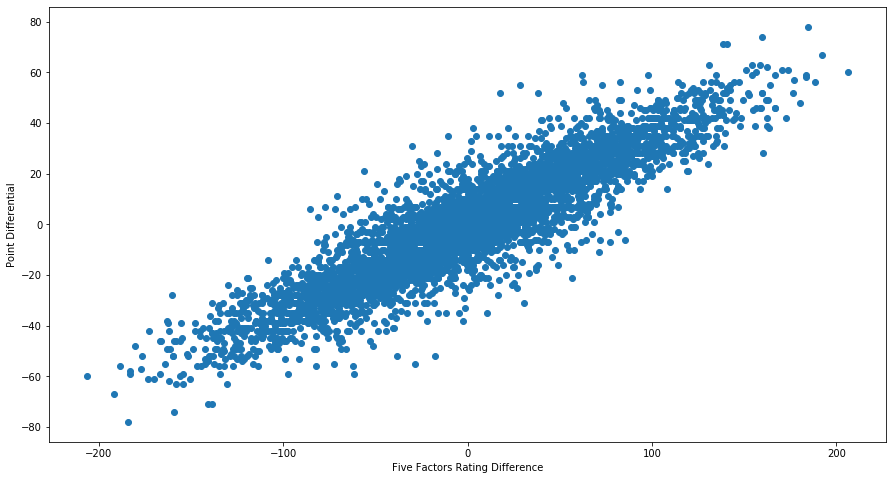

In [205]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(15,8))
ax.scatter(stored_game_boxes['5FRDiff'], stored_game_boxes.PtsDiff);
ax.set_xlabel("Five Factors Rating Difference")
ax.set_ylabel("Point Differential");

In [206]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,...,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,Hawai'i,2016,400869090,31.0,-20.0,0.008141,0.500000,0.138889,6.652778,23.000000,...,0.416667,0.604651,6.20,1.69,0.045977,0.22,150.278927,-7.279697,0.121822,0.903174
1,California,2016,400869090,51.0,20.0,0.991859,0.528736,0.149425,7.126437,37.846154,...,0.769231,0.573333,4.80,1.47,0.083333,-0.22,157.558624,7.279697,0.121822,0.903174
0,Tulane,2016,400869421,3.0,-4.0,0.649825,0.343284,0.089552,4.179104,25.800000,...,0.400000,0.333333,0.75,0.44,0.169811,0.22,35.188771,-20.665812,0.345832,0.180635
1,Wake Forest,2016,400869421,7.0,4.0,0.350175,0.339623,0.018868,3.094340,28.363636,...,0.181818,0.555556,3.50,0.22,0.119403,-0.22,55.854583,20.665812,0.345832,0.180635
0,Charlotte,2016,400869341,14.0,-56.0,0.000059,0.250000,0.066667,3.616667,31.214286,...,0.071429,0.400000,7.00,0.98,0.057971,-0.22,133.099845,-62.419334,1.044556,2.528887


In [207]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3.2)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.2)]
msk = np.random.rand(len(basis)) < 0.80
train_data = basis[msk]
test_data = basis[~msk]

In [208]:
outliers

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,...,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,Hawai'i,2016,400869180,3.0,-60.0,0.000004,0.310345,0.103448,4.241379,27.000000,...,0.363636,0.486486,0.750000,1.42,0.084746,0.22,34.052061,-206.318755,3.452640,2.709522
1,Michigan,2016,400869180,63.0,60.0,0.999996,0.694915,0.237288,8.694915,27.000000,...,0.777778,0.709091,7.000000,1.20,0.206897,-0.22,240.370816,206.318755,3.452640,2.709522
0,Bowling Green,2016,400869260,10.0,-67.0,0.000005,0.319444,0.041667,3.388889,22.642857,...,0.285714,0.410256,-1.000000,0.66,0.021739,0.44,22.102512,-191.999763,3.213019,3.025633
1,Ohio State,2016,400869260,77.0,67.0,0.999995,0.641304,0.097826,8.282609,31.615385,...,0.846154,0.658824,6.363636,0.22,0.111111,-0.44,214.102275,191.999763,3.213019,3.025633
0,Bowling Green,2016,400869287,3.0,-74.0,0.000002,0.297297,0.054054,3.878378,22.647059,...,0.235294,0.451613,0.750000,1.32,0.121622,0.88,31.401077,-159.359711,2.666804,3.341743
1,Memphis,2016,400869287,77.0,74.0,0.999998,0.472973,0.202703,8.189189,33.588235,...,0.588235,0.625000,7.000000,0.44,0.148649,-0.88,190.760787,159.359711,2.666804,3.341743
0,Michigan,2016,400869636,78.0,78.0,0.996516,0.555556,0.152778,8.347222,41.166667,...,0.611111,0.709091,7.000000,1.20,0.277778,0.00,197.384722,184.360103,3.085173,3.522378
1,Rutgers,2016,400869636,0.0,-78.0,0.003484,0.111111,0.000000,0.703704,24.588235,...,0.058824,0.000000,0.000000,1.20,0.097222,0.00,13.024619,-184.360103,3.085173,3.522378
0,Nevada,2019,401114193,6.0,-71.0,0.000006,0.253731,0.029851,2.686567,25.562500,...,0.125000,0.250000,3.000000,2.79,0.040541,1.32,69.504025,-140.810229,2.356388,3.206267
1,Oregon,2019,401114193,77.0,71.0,0.999994,0.513514,0.216216,8.418919,44.923077,...,0.846154,0.546875,6.363636,1.47,0.313433,-1.32,210.314254,140.810229,2.356388,3.206267


In [209]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,...,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,Hawai'i,2016,400869090,31.0,-20.0,0.008141,0.500000,0.138889,6.652778,23.000000,...,0.416667,0.604651,6.20,1.69,0.045977,0.22,150.278927,-7.279697,0.121822,0.903174
1,California,2016,400869090,51.0,20.0,0.991859,0.528736,0.149425,7.126437,37.846154,...,0.769231,0.573333,4.80,1.47,0.083333,-0.22,157.558624,7.279697,0.121822,0.903174
0,Tulane,2016,400869421,3.0,-4.0,0.649825,0.343284,0.089552,4.179104,25.800000,...,0.400000,0.333333,0.75,0.44,0.169811,0.22,35.188771,-20.665812,0.345832,0.180635
1,Wake Forest,2016,400869421,7.0,4.0,0.350175,0.339623,0.018868,3.094340,28.363636,...,0.181818,0.555556,3.50,0.22,0.119403,-0.22,55.854583,20.665812,0.345832,0.180635
0,Charlotte,2016,400869341,14.0,-56.0,0.000059,0.250000,0.066667,3.616667,31.214286,...,0.071429,0.400000,7.00,0.98,0.057971,-0.22,133.099845,-62.419334,1.044556,2.528887


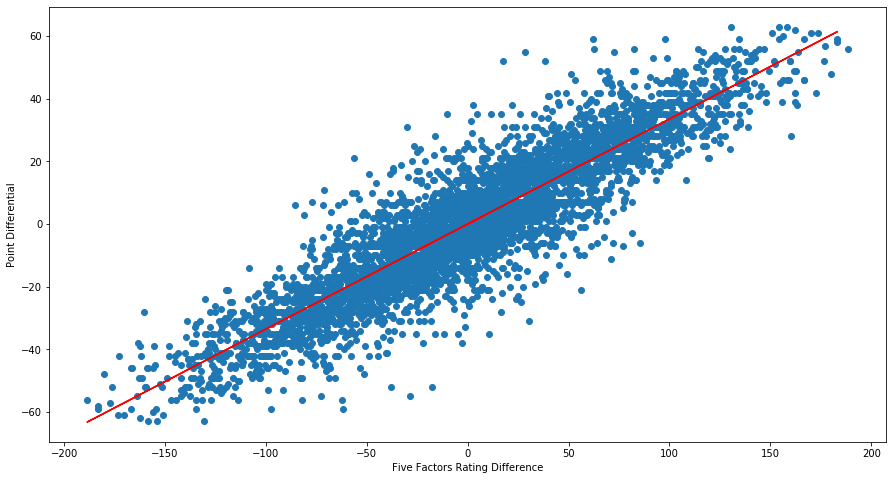

In [210]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

f, ax = plt.subplots(figsize=(15,8))
ax.scatter(basis['5FRDiff'], basis.PtsDiff)
ax.set_xlabel("Five Factors Rating Difference")
ax.set_ylabel("Point Differential")

xfit = test_data['5FRDiff']
yfit = model.predict(xfit[:, np.newaxis])
ax.plot(xfit, yfit, color='red', label='Linear Regression');

In [211]:
print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

test = pd.DataFrame({
    'ActPtsDiff':test_data['PtsDiff'],
    'PredPtsDiff' : yfit
})

test.corr()

Linear Regression: y = 0.33515x + 0.02273


,ActPtsDiff,PredPtsDiff
ActPtsDiff,1.00000,0.90265
PredPtsDiff,0.90265,1.00000


In [212]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = yfit.mean()
    std = yfit.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {stringify_entry(max_box_row.PtsDiff)}")
    print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    print("")
    proj_point_diff = model.coef_[0] * stringify_entry(max_box_row['5FRDiff']) + model.intercept_
    print(f"Proj MOV by 5FRDiff: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * stats.norm.cdf(z)):.2f}%")

In [213]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
5FRDiff for Virginia Tech: -29.075969462346364

Proj MOV by 5FRDiff: Virginia Tech by -10.0 (exact value: -9.72204591525589)
Z score: -0.48875492958597083
Win Prob for Virginia Tech: 31.25%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,26.0,2.214286,0.833333,0.428571,0.567568,5.166667,1.15,0.118421,-0.66,115.995178,29.075969
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,31.4,2.266667,0.625000,0.533333,0.448980,3.375000,1.81,0.158730,0.66,86.919209,-29.075969


In [214]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
5FRDiff for Georgia Tech: 7.106325738180573

Proj MOV by 5FRDiff: Georgia Tech by 2.0 (exact value: 2.404405496938411)
Z score: 0.12569030876402568
Win Prob for Georgia Tech: 55.00%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,17.444444,3.111111,0.500000,0.444444,0.47619,3.500000,0.93,0.177419,-0.66,78.592789,7.106326
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,38.750000,1.750000,0.333333,0.750000,0.40000,2.333333,1.59,0.158730,0.66,71.486463,-7.106326


In [215]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
5FRDiff for Georgia Tech: -16.462939295552943

Proj MOV by 5FRDiff: Georgia Tech by -5.0 (exact value: -5.4948044804468035)
Z score: -0.2745613223479697
Win Prob for Georgia Tech: 39.18%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,23.700000,2.600000,0.833333,0.600000,0.552239,4.5,0.98,0.087719,0.0,118.103750,16.462939
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,29.636364,2.545455,0.571429,0.636364,0.571429,4.0,0.98,0.075000,0.0,101.640811,-16.462939


In [216]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
5FRDiff for Mississippi State: 18.162417114542478

Proj MOV by 5FRDiff: Mississippi State by 6.0 (exact value: 6.109840824940504)
Z score: 0.31344408898494147
Win Prob for Mississippi State: 62.30%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.084507,5.563380,25.545455,1.818182,0.60,0.454545,0.473684,4.20,1.20,0.155172,0.22,86.898893,-18.162417
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,31.333333,1.750000,0.75,0.333333,0.533333,5.25,0.98,0.154930,-0.22,105.061310,18.162417


In [217]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
5FRDiff for Texas A&M: -10.705342021660101

Proj MOV by 5FRDiff: Texas A&M by -4.0 (exact value: -3.5651528868732956)
Z score: -0.17678620306175993
Win Prob for Texas A&M: 42.98%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,46.176471,4.235294,0.916667,0.705882,0.520548,5.166667,0.49,0.134615,0.0,159.850010,10.705342
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,45.157895,3.894737,0.923077,0.684211,0.505882,5.000000,0.49,0.133333,0.0,149.144668,-10.705342


In [218]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = yfit.mean()
    std = yfit.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    return stats.norm.cdf(z)

team_wp_frame = pd.DataFrame()
for team in team_list:
    team_wp_frame = team_wp_frame.append(pd.DataFrame({
        'team':[team],
        'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
    }))
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * 12.0)
team_wp_frame['proj_losses'] = 12 - team_wp_frame['proj_wins']
team_wp_frame.sort_values(by=['avg_win_prob'], ascending=False)

,team,avg_win_prob,proj_wins,proj_losses
0,Ohio State,0.928168,11.0,1.0
0,Alabama,0.923963,11.0,1.0
0,Georgia,0.860854,10.0,2.0
0,LSU,0.847335,10.0,2.0
0,Utah,0.842269,10.0,2.0
0,Wisconsin,0.825669,10.0,2.0
0,Clemson,0.814859,10.0,2.0
0,Louisiana,0.798672,10.0,2.0
0,Minnesota,0.790164,9.0,3.0
0,Appalachian State,0.777218,9.0,3.0


In [219]:
# Matchup Predictor?

def predict_matchup(team1, team2, year):
    team1_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team1) & (stored_game_boxes.Season == year)]['5FR'].mean()
    team2_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team2) & (stored_game_boxes.Season == year)]['5FR'].mean()
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
#     print(f"rating diff is {ffr_diff}")
    pred = model.predict([[ffr_diff]])
    mu = yfit.mean()
    std = yfit.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
#     print(f"{team1} should beat {team2} by {pred[0]} and should win {(100 * win_prob):.2f}% of the time")
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech','Clemson',2019)

[0.12170693769083585, -23.097683537398233]

In [220]:
team_triples = [
    ['Texas','Texas Tech',9.5],
    ['Virginia Tech','Virginia',2.5],
    ['Iowa','Nebraska',5.5],
    ['Missouri','Arkansas',11.5],
    ['Memphis','Cincinnati',11.5],
    ['Washington','Washington State',7.5],
    ['Georgia','Georgia Tech',28.5],
    ['Kentucky','Louisville',2.5],
    ['Clemson', 'South Carolina',27.5],
    ['Ohio State','Michigan',8.5],
    ['Indiana','Purdue',7.5],
    ['Miami','Duke',7.5],
    ['Wisconsin','Minnesota',2.5],
    ['Alabama','Auburn',3.5],
    ['Tennessee','Vanderbilt',22.5],
    ['Oregon','Oregon State',19.5],
    ['Notre Dame','Stanford',16.5],
    ['North Carolina','NC State',7.5],
    ['LSU','Texas A&M',16.5],
    ['Florida','Florida State',17.5],
    ['Utah','Colorado',17.5],
    ['Oklahoma','Oklahoma State',13.5],
    ['Arizona State','Arizona',13.5],
    ['Hawai\'i','Army',3.5]
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "team": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,team,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ats_pick
0,Alabama,Auburn,3.5,15.728432,0.788381,True,Alabama
0,Ohio State,Michigan,8.5,11.414502,0.719794,True,Ohio State
0,Clemson,South Carolina,27.5,19.737253,0.842297,False,South Carolina
0,Georgia,Georgia Tech,28.5,16.519656,0.799800,False,Georgia Tech
0,LSU,Texas A&M,16.5,12.830751,0.743441,False,Texas A&M
0,Oklahoma,Oklahoma State,13.5,10.835666,0.709834,False,Oklahoma State
0,Notre Dame,Stanford,16.5,9.923255,0.693807,False,Stanford
0,Utah,Colorado,17.5,7.710003,0.653403,False,Colorado
0,North Carolina,NC State,7.5,5.983693,0.620598,False,NC State
0,Memphis,Cincinnati,11.5,5.494472,0.611129,False,Cincinnati


In [221]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Could not find basic game data for game_id 401112521 locally, checking CFB Data API
Could not find drive data for game_id 401112521 locally, checking CFB Data API
Could not find play by play data for game_id 401112521 locally, checking CFB Data API
Actual Winner: Virginia
MOV: Virginia by 9
5FRDiff for Virginia: 23.489236730719554

Proj MOV by 5FRDiff: Virginia by 8.0 (exact value: 7.8951178201974015)
Z score: 0.4039037718372801
Win Prob for Virginia: 65.69%
Could not find basic game data for game_id 401112521 locally, checking CFB Data API
Could not find drive data for game_id 401112521 locally, checking CFB Data API
Could not find play by play data for game_id 401112521 locally, checking CFB Data API


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30,-9,0.577256,0.394231,0.153846,5.788462,31.600000,2.0,0.857143,0.466667,0.588235,4.285714,1.15,0.088608,0.44,107.241145,-23.489237
1,Virginia,2019,401112521,39,9,0.422744,0.367089,0.240506,9.481013,26.692308,3.0,0.857143,0.538462,0.478261,4.857143,0.71,0.115385,-0.44,130.730382,23.489237


In [222]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Actual Winner: North Carolina
MOV: North Carolina by 16.0
5FRDiff for North Carolina: 28.47003254525127

Proj MOV by 5FRDiff: North Carolina by 10.0 (exact value: 9.564425367002778)
Z score: 0.48848730238644317
Win Prob for North Carolina: 68.74%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,29.153846,2.923077,0.857143,0.538462,0.507692,5.428571,1.86,0.207547,0.0,132.523880,28.470033
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,26.923077,1.692308,0.750000,0.307692,0.631579,5.250000,1.86,0.127660,0.0,104.053848,-28.470033


In [223]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
5FRDiff for Pittsburgh: 30.547757744723825

Proj MOV by 5FRDiff: Pittsburgh by 10.0 (exact value: 10.260772393626139)
Z score: 0.5237710882364108
Win Prob for Pittsburgh: 69.98%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,35.285714,1.428571,0.666667,0.428571,0.470588,3.333333,1.91,0.183673,0.0,78.501272,30.547758
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,31.769231,0.769231,0.500000,0.307692,0.263158,2.500000,1.91,0.144928,0.0,47.953514,-30.547758
